# HARD diagrams


In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [110]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.utils import read_jsonl, write_jsonl, get_uid

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP_raw.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

5409

In [44]:
sa_dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
sa_dataset_map = {get_uid(p): p for p in sa_dataset}
len(sa_dataset)

4780

In [5]:
RESULTS_DIR = BASEDIR / "results/"

In [6]:
hendrycks_math_accuracies = {
    "o1-mini-2024-09-12": 0.900,
    "o1-preview-2024-09-12": 0.855,
    "claude-3-5-sonnet-20241022": 0.783,
    "claude-3-5-haiku-20241022": 0.692,
    "gemini-1.5-pro-002": 0.865,
    "gemini-1.5-flash-002": 0.779,
    "Meta-Llama-3.1-70B-Instruct-Turbo": 0.680,
    "Meta-Llama-3.1-405B-Instruct-Turbo": 0.738,
    "gpt-4o-2024-08-06": 0.759,
    "gpt-4o-mini-2024-07-18": 0.702,
}

In [7]:
# list to enforce ordering
MODELS = [
    "claude-3-5-haiku-20241022",
    "claude-3-5-sonnet-20241022",
    "Meta-Llama-3.1-70B-Instruct-Turbo",
    "Meta-Llama-3.1-405B-Instruct-Turbo",
    "gemini-1.5-flash-002",
    "gemini-1.5-pro-002",
    "gpt-4o-mini-2024-07-18",
    "gpt-4o-2024-08-06",
    "o1-mini-2024-09-12",
    "o1-preview-2024-09-12",
]
MODEL_DISPLAY_NAMES = [
    "Claude 3.5 Haiku",
    "Claude 3.5 Sonnet",
    "Llama 3.1 70B",
    "Llama 3.1 405B",
    "Gemini 1.5 Flash",
    "Gemini 1.5 Pro",
    "GPT-4o mini",
    "GPT-4o",
    "o1 mini",
    "o1 preview",
]

In [67]:
LEVELS = list(range(1, 7))
SUBJECTS = [
    'prealgebra',
    'algebra',
    'counting_and_probability',
    'geometry',
    'number_theory',
    'precalculus',
]
SUBJECTS_DISPLAY_ABBRS = [
    'P.Alg.',
    'Alg.',
    'C.&P.',
    'Geo.',
    'N.T.',
    'P.Calc.',
]
SUBJECTS_DISPLAY = {
    'prealgebra': {'full': 'Prealgebra', 'abbr': 'P.Alg.'},
    'algebra': {'full': 'Algebra', 'abbr': 'Alg.'},
    'geometry': {'full': 'Geometry', 'abbr': 'Geo.'},
    'counting_and_probability': {'full': 'Counting and\nProbability', 'abbr': 'C.&P.'},
    'number_theory': {'full': 'Number Theory', 'abbr': 'N.T.'},
    'precalculus':  {'full': 'Precalculus', 'abbr': 'P.Calc.'},
}

In [163]:
DIFFICULTY_PLOT_COLORS = plt.get_cmap('viridis')(np.linspace(0.2,0.8,len(LEVELS)))
DIFFICULTY_COLORS = plt.get_cmap('viridis')(np.linspace(0.2,0.8,len(LEVELS)))
DIFFICULTY_COLORS[:, -1] = 0.6

colors2 = np.array([[27,158,119],
                    [217,95,2],
                    [117,112,179],
                    [231,41,138],
                    [102,166,30],
                    [230,171,2]])/255
SUBJECT_COLORS = {subj: np.append(colors2, 0.6*np.ones(colors2.shape[0])[:, None], axis=1)[i] for i, subj in enumerate(sorted(SUBJECTS))}

# General

In [10]:
last_access_dates = {
    "o1-mini-2024-09-12": "2024-11-02",
    "o1-preview-2024-09-12": "2024-11-03",
    "claude-3-5-sonnet-20241022": "2024-11-02",
    "claude-3-5-haiku-20241022": "2024-11-06",
    "gemini-1.5-pro-002": "2024-11-13",
    "gemini-1.5-flash-002": "2024-11-02",
    "Meta-Llama-3.1-70B-Instruct-Turbo": "2024-11-02",
    "Meta-Llama-3.1-405B-Instruct-Turbo": "2024-11-05",
    "gpt-4o-2024-08-06": "2024-11-07",
    "gpt-4o-mini-2024-07-18": "2024-11-07",
}

In [11]:
print(f"\\begin{{tabular}}{{ lclll }} ")
print("\\toprule")
print(f"Model & Max Token Length & API & API Model Name & Last Access Date \\\\")
print("\\midrule")
for model, display_name in zip(MODELS, MODEL_DISPLAY_NAMES):
    model_name = model
    max_length = 2048
    if model.startswith("o1") or model.startswith("gpt"):
        api = "OpenAI"
        if model.startswith("o1"):
            max_length = 8192
    elif model.startswith("claude"):
        api = "Anthropic"
    elif model.startswith("gemini"):
        api = "Google VertexAI"
    elif model.startswith("Meta-Llama"):
        api = "Together AI"
        model_name = f"meta-llama/{model}"
        if "405B" in model:
            max_length = 4096
    else:
        raise NotImplementedError(model)

    print(f"{display_name} & {max_length} & {api} & {model_name} & {last_access_dates[model]} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ lclll } 
\toprule
Model & Max Token Length & API & API Model Name & Last Access Date \\
\midrule
Claude 3.5 Haiku & 2048 & Anthropic & claude-3-5-haiku-20241022 & 2024-11-06 \\
Claude 3.5 Sonnet & 2048 & Anthropic & claude-3-5-sonnet-20241022 & 2024-11-02 \\
Llama 3.1 70B & 2048 & Together AI & meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo & 2024-11-02 \\
Llama 3.1 405B & 4096 & Together AI & meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo & 2024-11-05 \\
Gemini 1.5 Flash & 2048 & Google VertexAI & gemini-1.5-flash-002 & 2024-11-02 \\
Gemini 1.5 Pro & 2048 & Google VertexAI & gemini-1.5-pro-002 & 2024-11-13 \\
GPT-4o mini & 2048 & OpenAI & gpt-4o-mini-2024-07-18 & 2024-11-07 \\
GPT-4o & 2048 & OpenAI & gpt-4o-2024-08-06 & 2024-11-07 \\
o1 mini & 8192 & OpenAI & o1-mini-2024-09-12 & 2024-11-02 \\
o1 preview & 8192 & OpenAI & o1-preview-2024-09-12 & 2024-11-03 \\
\bottomrule
\end{tabular}


## Subject annotation details

In [13]:
subject_criteria = {
    "prealgebra": "arithmetic, speed/distance, unit conversion, simple equations",
    "algebra": "arithmetic/geometric sequences, systems of equations, logs, Vieta's",
    "counting_and_probability": "stars and bars, probability, game theory",
    "geometry": "areas, triangles, circles, polygons",
    "number_theory": "digit sums, modulo/remainders",
    "precalculus": "trigonometry including law of (co)sines, complex numbers, matrices",
    "calculus": "limits, continuity",
}

print(f"\\begin{{tabular}}{{ ll }} ")
print("\\toprule")
print(f"Subject & Example Criteria \\\\")
print("\\midrule")
for subj, criteria in subject_criteria.items():
    print(f"{subj} & {criteria} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ ll } 
\hline
Subject & Example Criteria \\
\hline
prealgebra & arithmetic/computation, speed/distance, unit conversion, simple equations \\
algebra & arithmetic/geometric sequences, systems of equations, logs, Vieta's \\
geometry & areas, triangles, circles, polygons \\
counting_and_probability & stars and bars, probability, game theory \\
number_theory & digit sums, modulo/remainders \\
precalculus & trigonometry including law of (co)sines, complex numbers, matrices \\
calculus & limits, continuity \\
\hline
\end{tabular}


In [43]:
ANNOTATION_SUBJECTS = [
    "prealgebra",
    "algebra", # arithmetic/geometric sequences
    "counting_and_probability",
    "geometry",
    "number_theory",
    "precalculus", # trig, complex numbers, matrices
    "calculus",
    "other"
]

In [44]:
problem = dataset_map["1950/AHSME/1"]
choice_text = '\n\n'.join(['{}. {}'.format(c, problem['choices'][c]) for c in problem['choices']])
text = '### Problem\n\n{}\n\n{}\n\n### Solution\n\n{}'.format(problem['problem'], 
                                                              choice_text,
                                                              problem['solution_1'])
text = text.replace('\\(', '$').replace('\\)', '$').replace('\\[', '$$').replace('\\]', '$$')

In [46]:
print("UID:", get_uid(problem))
print("URL:", problem["url"])
display(Markdown(text))
for i, subj in enumerate(ANNOTATION_SUBJECTS):
    print(f"({i}): {subj}")

subject_num = input("Subject (input a number, or q to quit)> ")
notes = input("Any notes, or q to quit? (standard prefixes are \'need choices\', \'parse problem\', \'parse solution\', etc)")

UID: 1950/AHSME/1
URL: https://artofproblemsolving.com/wiki/index.php/1950_AHSME_Problems/Problem_1


### Problem

If $64$ is divided into three parts proportional to $2$, $4$, and $6$, the smallest part is:

A. $5\frac{1}{3}$

B. $11$

C. $10\frac{2}{3}$

D. $5$

E. $\text{None of these answers}$

### Solution

If the three numbers are in proportion to $2:4:6$, then they should also be in proportion to $1:2:3$. This implies that the three numbers can be expressed as $x$, $2x$, and $3x$. Add these values together to get: 
$$x+2x+3x=6x=64$$
Divide each side by 6 and get that 
$$x=\frac{64}{6}=\frac{32}{3}=10 \frac{2}{3}$$
which is $\boxed{10\frac{2}{3}}$.

(0): prealgebra
(1): algebra
(2): counting_and_probability
(3): geometry
(4): number_theory
(5): precalculus
(6): calculus
(7): other


Subject (input a number, or q to quit)>  0
Any notes, or q to quit? (standard prefixes are 'need choices', 'parse problem', 'parse solution', etc) q


# Dataset Stats

In [45]:
full_df = pd.DataFrame(dataset)
sa_df = pd.DataFrame(sa_dataset)
sa_df = sa_df[sa_df['subject'] != 'calculus']

In [46]:
sa_df.columns

Index(['year', 'contest', 'number', 'level', 'subject', 'multiple_choice_only',
       'problem', 'answer', 'solution_1', 'num_solutions', 'solution_2',
       'solution_3', 'solution_4', 'solution_5', 'solution_6', 'solution_7',
       'solution_8', 'solution_9', 'solution_10', 'solution_11', 'solution_12',
       'solution_13', 'solution_14'],
      dtype='object')

In [162]:
print("Number of olympiad/proof-based problems:", full_df['contest'].str.endswith('MO').sum())
print("Number of problems that can only be solved as MCQ (and not short answer):", full_df['multiple_choice_only'].sum())
print("Number of MCQ problems:", full_df['choices'].notna().sum())

Number of olympiad/proof-based problems: 311
Number of problems that can only be solved as MCQ (and not short answer): 313
Number of MCQ problems: 4115


In [50]:
full_df[full_df['subject'] == 'calculus']

,year,contest,number,url,level,subject,multiple_choice_only,full_text,num_gpt4_tokens,choices,...,solution_10_metadata,solution_10,solution_11_metadata,solution_11,solution_12_metadata,solution_12,solution_13_metadata,solution_13,solution_14_metadata,solution_14
38,1950,AHSME,40,https://artofproblemsolving.com/wiki/index.php...,3,calculus,False,# Problem\nThe limit of $\frac {x^2-1}{x-1}$ a...,334,"{'A': '$0$', 'B': '$\text{Indeterminate}$', 'C...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,1950,AHSME,41,https://artofproblemsolving.com/wiki/index.php...,4,calculus,False,# Problem\nThe least value of the function $ax...,391,"{'A': '$-\dfrac{b}{a}$', 'B': '$-\dfrac{b}{2a}...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,1952,AHSME,36,https://artofproblemsolving.com/wiki/index.php...,3,calculus,False,"# Problem\nTo be continuous at $x = - 1$, the ...",225,"{'A': '$- 2$', 'B': '$0$', 'C': '$\frac {3}{2}...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,1967,AHSME,23,https://artofproblemsolving.com/wiki/index.php...,3,calculus,False,# Problem\nIf $x$ is real and positive and gro...,352,"{'A': '$0$', 'B': '$1$', 'C': '$3$', 'D': '$4$...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,1968,AHSME,35,https://artofproblemsolving.com/wiki/index.php...,4,calculus,False,"# Problem\n[asy] draw(arc((0,0),10, 0, 180),bl...",1167,"{'A': '$0$', 'B': '$1$', 'C': '$\sqrt{2}$', 'D...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1054,1980,USAMO,5,https://artofproblemsolving.com/wiki/index.php...,8,calculus,False,"# Problem\nIf $x, y, z$ are reals such that $0...",251,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
section_labels = ['Proof-\nbased', 'Calculus\nQuestions', 'Short answer', 'Needs\nchoices']
sections = [(full_df['contest'].str.endswith('MO') & (full_df['subject'] != 'calculus')).sum(), 
            (full_df['subject'] == 'calculus').sum(), 
            0,
           (full_df['multiple_choice_only'] & (full_df['subject'] != 'calculus')).sum()]
sections[2] = len(full_df) - sum(sections)
print(sections)
section_labels[1] = ' '.join([str(sections[1]), section_labels[1]])
num_mc_qs = ((full_df['subject'] != 'calculus') & full_df['choices'].notna()).sum()
print(num_mc_qs)

[np.int64(310), np.int64(6), np.int64(4780), np.int64(313)]
4110


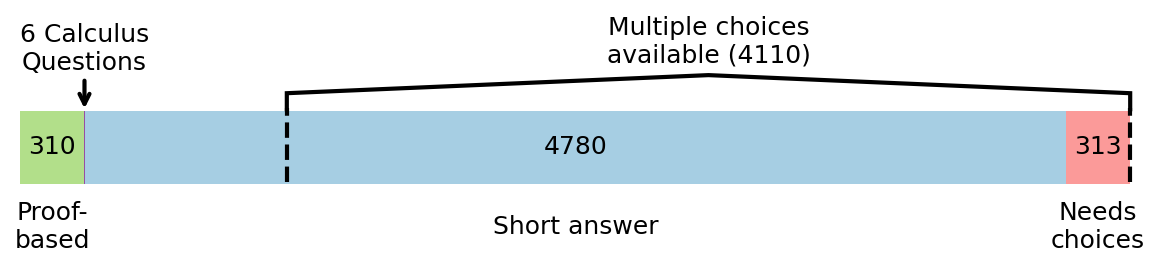

In [54]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

mc_annot_lw = 3
matplotlib.rcParams.update({'font.size': 18})

def create_brace(x1, x2, y, height=0.1):
    """Create a smoother curly brace path between two x-coordinates"""
    # Control points for the curly brace
    xmid = (x1 + x2) * 0.5
    y_height = y + height
    
    # More control points for smoother curve
    verts = [
        (x1, y),  # Start
        (x1, y + height/3),
        (x1, y + height/2),
        (xmid - height, y + height),  # Middle left
        (xmid, y + height),  # Middle
        (xmid + height, y + height),  # Middle right
        (x2, y + height/2),
        (x2, y + height/3),
        (x2, y)  # End
    ]
    
    codes = [Path.MOVETO] + [Path.CURVE3] * (len(verts)-1)
    
    return PathPatch(Path(verts, codes),
                    facecolor='none',
                    edgecolor='black',
                    linewidth=mc_annot_lw)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 3))

# Data for the sections
total_length = sum(sections)
colors = ['#b2df8a', '#984ea3', '#a6cee3', '#fb9a99']

# Create the stacked bar
left = 0
rectangles = []
for i, (section, color) in enumerate(zip(sections, colors)):
    rect = plt.Rectangle((left, 0), section, 0.5, facecolor=color)
    ax.add_patch(rect)
    rectangles.append(rect)
    left += section

# Add annotations below and above
for i, (rect, label) in enumerate(zip(rectangles, section_labels)):
    x = rect.get_x() + rect.get_width()/2
    if i == 1:  # Calculus section (above with arrow)
        ax.annotate(label, 
                   xy=(x, 0.5),
                   xytext=(x, 0.75),
                   ha='center',
                   va='bottom',
                   arrowprops=dict(arrowstyle='->', linewidth=3))
    else:  # Other sections (below)
        ax.annotate(label,
                   xy=(x, 0),
                   xytext=(x, -0.3),
                   ha='center',
                   va='center')
        ax.annotate(sections[i],
                   xy=(x, 0),
                   xytext=(x, 0.25),
                   ha='center',
                   va='center')

# Add the multiple choice split line (shorter)
mc_split = total_length - num_mc_qs # First split point
ax.axvline(x=mc_split, color='black', linestyle='--', linewidth=mc_annot_lw, ymin=0.3, ymax=0.6)
ax.axvline(x=total_length, color='black', linestyle='--', linewidth=mc_annot_lw, ymin=0.3, ymax=0.6)

# Add curly brace for multiple choice section
brace = create_brace(mc_split, total_length, 0.5, height=0.25)
ax.add_patch(brace)

# Add the "Multiple choice available" text above the brace
ax.annotate('Multiple choices\navailable ({})'.format(num_mc_qs),
           xy=(mc_split + (total_length - mc_split)/2, 0.7),
           xytext=(mc_split + (total_length - mc_split)/2, 0.8),
           ha='center',
           va='bottom')

# Set the axis limits and remove ticks
ax.set_xlim(-50, total_length + 50)
ax.set_ylim(-0.5, 1.2)
ax.set_xticks([])
ax.set_yticks([])

# Remove axis lines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig(BASEDIR / '../images/dataset_composition.pdf', bbox_inches='tight')
plt.show()

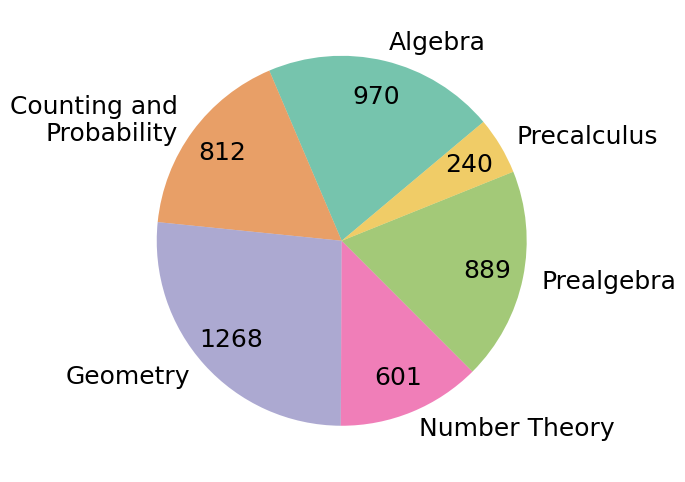

In [76]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
fig.set_size_inches(7,7)
by_subject = sa_df.groupby('subject')['year'].count()
ax.pie(by_subject,
       labels=[SUBJECTS_DISPLAY[s]['full'] for s in by_subject.index],
       autopct=lambda x: round(sa_df['year'].count()*x/100),
       pctdistance=0.8, startangle=40, 
       colors=[SUBJECT_COLORS[subj] for subj in by_subject.index]) 
plt.tight_layout()
fig.savefig(BASEDIR / '../images/subject_breakdown.pdf', bbox_inches='tight')

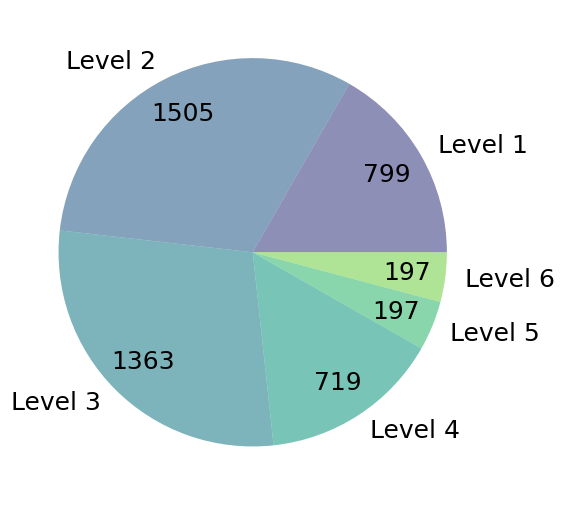

In [77]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
by_diff = sa_df.groupby('level')['year'].count()
ax.pie(by_diff, labels=['Level {}'.format(l) for l in by_diff.index],
       autopct=lambda x: round(sa_df['year'].count()*x/100),
       pctdistance=0.8, startangle=0, 
       colors=DIFFICULTY_COLORS)
plt.tight_layout()
fig.savefig(BASEDIR / '../images/level_breakdown.pdf', bbox_inches='tight')

[2396 1027  595  345  185  232]
['One soln.', 'Two solns.', 'Three solns.', 'Four solns.', 'Five solns.', '>Five solns.']


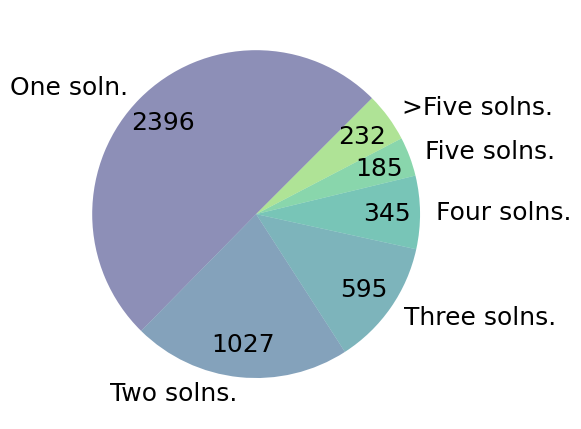

In [80]:
max_num_solutions = 6
numbers = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

vals = [sa_df['solution_{}'.format(i)].count() for i in range(max_num_solutions, 0, -1)]
num_solutions = np.flip(np.diff(vals, prepend=0))
label_num_solutions = (['One soln.'] 
                       + ['{} solns.'.format(s) for s in numbers[1:max_num_solutions-1]] 
                       + ['>{} solns.'.format(numbers[max_num_solutions-2])])
print(num_solutions)
print(label_num_solutions)

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
c = plt.get_cmap('viridis')(np.linspace(0.2,0.8,len(by_diff)))
c[:, -1] = 0.6
ax.pie(num_solutions, labels=label_num_solutions,
      autopct=lambda x: round(sa_df['year'].count()*x/100),
      pctdistance=0.8, startangle=45, 
      colors=c) 
plt.tight_layout()
fig.savefig(BASEDIR / '../images/solution_breakdown.pdf', bbox_inches='tight')

The maximum number of solutions (from inspection) is 14.

In [81]:
sa_df[sa_df['solution_14'].notna()]

,year,contest,number,level,subject,multiple_choice_only,problem,answer,solution_1,num_solutions,...,solution_5,solution_6,solution_7,solution_8,solution_9,solution_10,solution_11,solution_12,solution_13,solution_14
4085,2019,AMC_8,24,2,geometry,False,"In triangle $\triangle ABC$, point $D$ divides...",$30$,We use the line-segment ratios to infer area r...,14,...,Extend $\overline{BD}$ to $G$ such that $\over...,"[asy] size(8cm); pair A, B, C, D, E, F; B = (0...","Let $ADB$ be a right triangle, and $BD=CD$\nLe...",[asy] import graph; size(15cm); real labelscal...,"[asy] import geometry; unitsize(2cm); pair A,B...","[asy] unitsize(2cm); pair A,B,C,DD,EE,FF; B = ...","[asy] unitsize(2cm); pair A,B,C,D,E,F,a,b,c,d,...","[asy] unitsize(2cm); pair A,B,C,DD,EE,FF,G; B ...","[asy] size(8cm); pair A, B, C, D, E, F; B = (0...","[asy] size(8cm); pair A, B, C, D, E, F; B = (0..."


In [82]:
max_num_solutions = 14
vals = [sa_df['solution_{}'.format(i)].count() for i in range(max_num_solutions, 0, -1)]
num_solutions = np.flip(np.diff(vals, prepend=0))

print(num_solutions)
print(np.sum(num_solutions*np.arange(1, 15)))

[2396 1027  595  345  185  100   67   24   17    8    8    6    1    1]
10221


# Short Answer Accuracies

In [12]:
results_list = []
for model in MODELS:
    results = pd.read_csv(RESULTS_DIR / model / "results.csv")
    results["model"] = model
    if "reasoning_tokens" not in results.columns:
        results["reasoning_tokens"] = np.nan
    results = results.set_index(["model", "uid", "level", "subject"]).sort_index()
    results_list.append(results)
results = pd.concat(results_list).drop(columns=["has_asy_problem", "has_asy_solution"])

In [13]:
results.groupby("model")["is_correct"].count()

model
Meta-Llama-3.1-405B-Instruct-Turbo    4780
Meta-Llama-3.1-70B-Instruct-Turbo     4780
claude-3-5-haiku-20241022             4780
claude-3-5-sonnet-20241022            4780
gemini-1.5-flash-002                  4780
gemini-1.5-pro-002                    4780
gpt-4o-2024-08-06                     4780
gpt-4o-mini-2024-07-18                4780
o1-mini-2024-09-12                    4780
o1-preview-2024-09-12                 4780
Name: is_correct, dtype: int64

In [14]:
tmpdf = results.unstack("model")
tmpdf[(~tmpdf[[("is_correct", m) for m in MODELS]]).all(axis=1)].head()

mcq_only  \
model                          Meta-Llama-3.1-405B-Instruct-Turbo   
uid           level subject                                         
1950/AHSME/13 2     algebra                                 False   
1950/AHSME/39 3     algebra                                 False   
1951/AHSME/5  2     prealgebra                              False   
1951/AHSME/6  2     geometry                                False   
1952/AHSME/25 3     prealgebra                              False   

                                                                  \
model                          Meta-Llama-3.1-70B-Instruct-Turbo   
uid           level subject                                        
1950/AHSME/13 2     algebra                                False   
1950/AHSME/39 3     algebra                                False   
1951/AHSME/5  2     prealgebra                             False   
1951/AHSME/6  2     geometry                               False   
1952/AHSME/25 3     prealgebra                             False   

                                                          \
model                          claude-3-5-haiku-20241022   
uid           level subject                                
1950/AHSME/13 2     algebra                        False   
1950/AHSME/39 3     algebra                        False   
1951/AHSME/5  2     prealgebra                     False   
1951/AHSME/6  2     geometry                       False   
1952/AHSME/25 3     prealgebra                     False   

                                                           \
model                          claude-3-5-sonnet-20241022   
uid           level subject                                 
1950/AHSME/13 2     algebra                         False   
1950/AHSME/39 3     algebra                         False   
1951/AHSME/5  2     prealgebra                      False   
1951/AHSME/6  2     geometry                        False   
1952/AHSME/25 3     prealgebra                      False   

                                                                        \
model                          gemini-1.5-flash-002 gemini-1.5-pro-002   
uid           level subject                                              
1950/AHSME/13 2     algebra                   False              False   
1950/AHSME/39 3     algebra                   False              False   
1951/AHSME/5  2     prealgebra                False              False   
1951/AHSME/6  2     geometry                  False              False   
1952/AHSME/25 3     prealgebra                False              False   

                                                                         \
model                          gpt-4o-2024-08-06 gpt-4o-mini-2024-07-18   
uid           level subject                                               
1950/AHSME/13 2     algebra                False                  False   
1950/AHSME/39 3     algebra                False                  False   
1951/AHSME/5  2     prealgebra             False                  False   
1951/AHSME/6  2     geometry               False                  False   
1952/AHSME/25 3     prealgebra             False                  False   

                                                                         ...  \
model                          o1-mini-2024-09-12 o1-preview-2024-09-12  ...   
uid           level subject                                              ...   
1950/AHSME/13 2     algebra                 False                 False  ...   
1950/AHSME/39 3     algebra                 False                 False  ...   
1951/AHSME/5  2     prealgebra              False                 False  ...   
1951/AHSME/6  2     geometry                False                 False  ...   
1952/AHSME/25 3     prealgebra              False                 False  ...   

                                                 reasoning_tokens  \
model                          Meta-Llama-3.1-405B-Instruct-Turbo   
uid           le

In [15]:
tmpdf[(~tmpdf[[("is_correct", m) for m in MODELS]]).all(axis=1)][["predict", "is_correct"]].iloc[40:45]

predict  \
model                             Meta-Llama-3.1-405B-Instruct-Turbo   
uid           level subject                                            
1960/AHSME/13 2     geometry                        \boxed{triangle}   
1960/AHSME/14 2     algebra                  \boxed{\frac{6-a}{3-b}}   
1960/AHSME/16 2     number_theory                          \boxed{3}   
1960/AHSME/21 3     geometry                         \boxed{(a+b)^2}   
1960/AHSME/28 3     algebra                                \boxed{2}   

                                                                     \
model                             Meta-Llama-3.1-70B-Instruct-Turbo   
uid           level subject                                           
1960/AHSME/13 2     geometry                       \boxed{triangle}   
1960/AHSME/14 2     algebra                               \boxed{3}   
1960/AHSME/16 2     number_theory                       \boxed{234}   
1960/AHSME/21 3     geometry                        \boxed{(a+b)^2}   
1960/AHSME/28 3     algebra                               \boxed{0}   

                                                             \
model                             claude-3-5-haiku-20241022   
uid           level subject                                   
1960/AHSME/13 2     geometry                      \triangle   
1960/AHSME/14 2     algebra           a \neq 0 and b \neq 3   
1960/AHSME/16 2     number_theory                         3   
1960/AHSME/21 3     geometry                        (a+b)^2   
1960/AHSME/28 3     algebra                               0   

                                                              \
model                             claude-3-5-sonnet-20241022   
uid           level subject                                    
1960/AHSME/13 2     geometry                       \triangle   
1960/AHSME/14 2     algebra                         b \neq 3   
1960/AHSME/16 2     number_theory                          3   
1960/AHSME/21 3     geometry                         (a+b)^2   
1960/AHSME/28 3     algebra                                0   

                                                                           \
model                             gemini-1.5-flash-002 gemini-1.5-pro-002   
uid           level subject                                                 
1960/AHSME/13 2     geometry           \text{triangle}   \boxed{triangle}   
1960/AHSME/14 2     algebra                   b \neq 3           b \neq 3   
1960/AHSME/16 2     number_theory                    3          \boxed{3}   
1960/AHSME/21 3     geometry                   (a+b)^2            (a+b)^2   
1960/AHSME/28 3     algebra                          0       no solutions   

                                                                            \
model                             gpt-4o-2024-08-06 gpt-4o-mini-2024-07-18   
uid           level subject                                                  
1960/AHSME/13 2     geometry               triangle               triangle   
1960/AHSME/14 2     algebra                b \neq 3               b \neq 3   
1960/AHSME/16 2     number_theory               234                      3   
1960/AHSME/21 3     geometry              (a + b)^2              (a + b)^2   
1960/AHSME/28 3     algebra             no solution                      0   

                                                        \
model                               o1-mini-2024-09-12   
uid           level subject                              
1960/AHSME/13 2     geometry                  triangle   
1960/AHSME/14 2     algebra        \frac{6 - a}{3 - b}   
1960/AHSME/16 2     number_theory                    3   
1960/AHSME/21 3     geometry                 (a + b)^2   
1960/AHSME/28 3     algebra                no solution   

                                                                                      \
model                                                          o1-preview-2024-09-12   
uid           

In [16]:
overall_accs = results.groupby("model")["is_correct"].mean()

bylevel_accs = results.groupby(["model", "level"])["is_correct"].mean()
bysubject_accs = results.groupby(["model", "subject"])["is_correct"].mean()

overall_accs

model
Meta-Llama-3.1-405B-Instruct-Turbo    0.512971
Meta-Llama-3.1-70B-Instruct-Turbo     0.433054
claude-3-5-haiku-20241022             0.378452
claude-3-5-sonnet-20241022            0.485565
gemini-1.5-flash-002                  0.522594
gemini-1.5-pro-002                    0.580962
gpt-4o-2024-08-06                     0.469665
gpt-4o-mini-2024-07-18                0.457113
o1-mini-2024-09-12                    0.759205
o1-preview-2024-09-12                 0.682008
Name: is_correct, dtype: float64

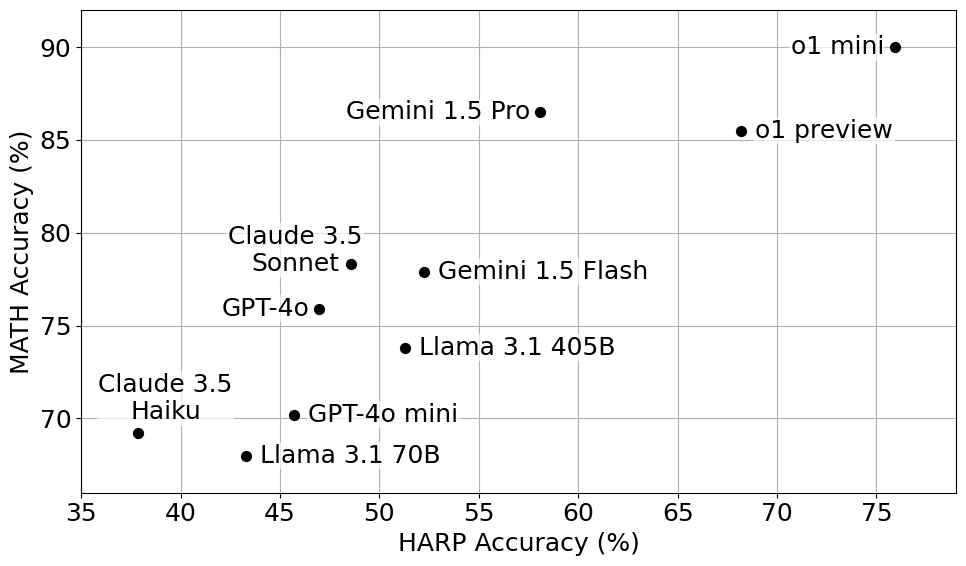

In [17]:
x = [100*overall_accs[model] for model in MODELS]
y = [100*hendrycks_math_accuracies[model] for model in MODELS]

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10,6))

label_offsets = {
    "o1 mini": (-75, 0),
#     "o1 preview": (-40, -10),
    "Gemini 1.5 Pro": (-140, 0),
#     "Gemini 1.5 Flash": (10, -8),
    "Claude 3.5 Sonnet": (-40, 10),
    "GPT-4o": (-70, 0),
#     "Llama 3.1 405B": (10, -15),
#     "GPT-4o mini": (-20, -15),
    "Claude 3.5 Haiku": (20, 25),
#     "Llama 3.1 70B": (10, -15)
}

for i, txt in enumerate(MODEL_DISPLAY_NAMES):
    offset = label_offsets.get(txt, (10 ,0))
    ha='left'
    if txt.startswith('Claude 3.5'):
        txt = 'Claude 3.5\n'+txt.split(' ')[-1]
        ha = 'center'
    # bbox makes a white background to avoid weirdness with grid lines
    ax.annotate(txt, (x[i], y[i]), xytext=offset, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1),
                textcoords="offset points", ha=ha, va='center')

# zorder to make sure it's on top
ax.scatter(x, y, color="black", s=50, zorder=10) 
    
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlim(35, 79)
plt.ylim(66, 92)
plt.xlabel("HARP Accuracy (%)")
plt.ylabel("MATH Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig(BASEDIR / "../images/HARPvsMATH.pdf", bbox_inches='tight')
plt.show()

In [18]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(LEVELS)} {'c'*len(SUBJECTS)} c }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in LEVELS])
bysubject_header_str = " & ".join([s.replace("&", "\\&") for s in SUBJECTS_DISPLAY_ABBRS])
print(f"Model & Overall Acc. & {bylevel_header_str} & {bysubject_header_str} & MATH Acc.\\\\")
print("\\midrule")
for model, display_name in zip(MODELS, MODEL_DISPLAY_NAMES):
    overall_acc = overall_accs[model]

    by_level_str = " & ".join([f"{100*bylevel_accs[model][lvl]:.01f}" for lvl in LEVELS])
    by_subject_str = " & ".join([f"{100*bysubject_accs[model][subj]:.01f}" for subj in SUBJECTS])

    print(f"{display_name} & {100*overall_acc:.01f} & {by_level_str} & {by_subject_str} & {100*hendrycks_math_accuracies[model]:.01f} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccccc cccccc c } 
\toprule
Model & Overall Acc. & L1 & L2 & L3 & L4 & L5 & L6 & P.Alg. & Alg. & C.\&P. & Geo. & N.T. & P.Calc. & MATH Acc.\\
\midrule
Claude 3.5 Haiku & 37.8 & 66.1 & 50.9 & 29.5 & 12.5 & 8.1 & 3.6 & 66.5 & 39.3 & 30.9 & 27.0 & 33.4 & 17.9 & 69.2 \\
Claude 3.5 Sonnet & 48.6 & 75.7 & 64.0 & 41.5 & 21.8 & 9.6 & 5.6 & 75.5 & 50.6 & 45.0 & 36.2 & 44.4 & 28.3 & 78.3 \\
Llama 3.1 70B & 43.3 & 65.0 & 51.4 & 35.5 & 25.7 & 26.9 & 27.9 & 65.1 & 48.2 & 42.4 & 29.7 & 38.6 & 29.6 & 68.0 \\
Llama 3.1 405B & 51.3 & 71.0 & 58.3 & 45.3 & 34.1 & 35.5 & 38.1 & 70.9 & 55.3 & 50.1 & 38.1 & 49.9 & 40.0 & 73.8 \\
Gemini 1.5 Flash & 52.3 & 72.0 & 65.4 & 48.4 & 31.8 & 15.2 & 9.6 & 73.5 & 60.0 & 45.1 & 39.7 & 51.4 & 35.4 & 77.9 \\
Gemini 1.5 Pro & 58.1 & 77.5 & 70.6 & 56.4 & 37.6 & 19.3 & 9.6 & 78.2 & 65.7 & 51.2 & 45.9 & 58.1 & 40.8 & 86.5 \\
GPT-4o mini & 45.7 & 69.1 & 58.6 & 41.0 & 22.1 & 11.7 & 5.1 & 69.4 & 51.2 & 43.2 & 30.0 & 45.3 & 27.9 & 70.2 \\
GPT-4o & 47.0 & 71.5

In [19]:
reason_counts_df = results.groupby(["model", "level"])["reason"].value_counts()
total_counts_df = results.groupby(["model", "level"])["reason"].count()

print(f"\\begin{{tabular}}{{ l c {'c'*len(LEVELS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in LEVELS])
# bysubject_header_str = " & ".join([s.replace("&", "\\&") for s in SUBJECTS_DISPLAY_ABBRS])
print(f"Model & Overall & {bylevel_header_str} \\\\")
print("\\midrule")
for model, display_name in zip(MODELS, MODEL_DISPLAY_NAMES):
    overall_non_stop = 1 - results.query("subject != 'calculus' & model == @model")["reason"].value_counts()["stop"] / results.query("subject != 'calculus' & model == @model")["reason"].count()
    by_level_str = " & ".join([f"{100 * (1 - reason_counts_df[model][lvl] / total_counts_df[model][lvl])["stop"]:.01f}" for lvl in LEVELS])

    print(f"{display_name} & {100*overall_non_stop:.01f} & {by_level_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccccc } 
\toprule
Model & Overall & L1 & L2 & L3 & L4 & L5 & L6 \\
\midrule
Claude 3.5 Haiku & 0.1 & 0.3 & 0.0 & 0.0 & 0.1 & 0.0 & 0.0 \\
Claude 3.5 Sonnet & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
Llama 3.1 70B & 14.1 & 6.6 & 11.5 & 15.6 & 21.1 & 19.3 & 24.4 \\
Llama 3.1 405B & 4.2 & 1.0 & 3.3 & 5.4 & 5.0 & 8.1 & 9.1 \\
Gemini 1.5 Flash & 0.3 & 0.3 & 0.1 & 0.3 & 0.8 & 0.5 & 1.0 \\
Gemini 1.5 Pro & 0.3 & 0.0 & 0.1 & 0.1 & 0.4 & 1.0 & 2.5 \\
GPT-4o mini & 2.2 & 0.8 & 1.9 & 2.4 & 2.1 & 7.1 & 4.6 \\
GPT-4o & 3.6 & 1.0 & 1.7 & 4.0 & 6.4 & 9.1 & 9.1 \\
o1 mini & 6.3 & 0.5 & 1.4 & 4.5 & 11.8 & 24.9 & 39.6 \\
o1 preview & 11.3 & 0.9 & 2.8 & 9.5 & 20.9 & 42.6 & 64.0 \\
\bottomrule
\end{tabular}


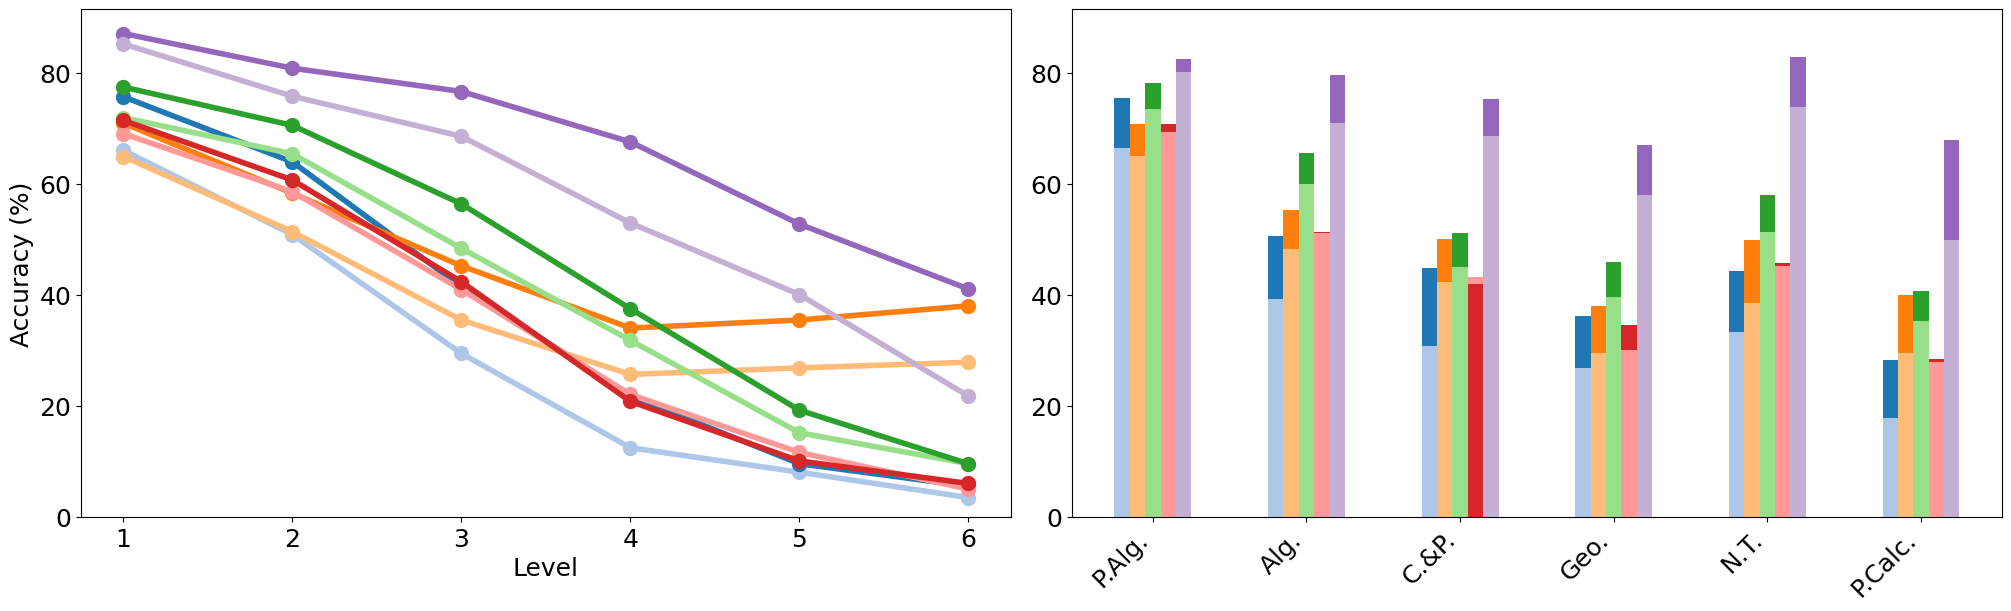

<Figure size 200x200 with 0 Axes>

In [20]:
from matplotlib.colors import rgb2hex
tab10 = plt.get_cmap('tab20')
colors = [rgb2hex(tab10(i)) for i in range(10)]
width = 0.1  # the width of the bars

fig, ax = plt.subplots(1, 2, figsize=(20,6), layout='constrained')

for idx, model in enumerate(MODELS):
    df = bylevel_accs[model]
    cidx = idx if idx >= 8 else idx ^ 1
    ax[0].plot(df.index, 100*np.array(df.to_list()), 'o-', label=MODEL_DISPLAY_NAMES[idx], color=colors[cidx], lw=4, markersize=10)

# plt.title("Per-difficulty Performance on HARD-Math of Various Models")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Accuracy (%)")
# plt.savefig("HARD_by_model.pdf", bbox_inches='tight')

for idx in range(5):
    if idx < 4:
        sidx, lidx = 2 * idx, 2 * idx + 1
    else:
        sidx, lidx = 2 * idx + 1, 2 * idx

    if idx != 3:
        for jdx in [lidx, sidx]:
            df = bysubject_accs[MODELS[jdx]][SUBJECTS]
            cjdx = jdx if jdx >= 8 else jdx ^ 1
            ax[1].bar(np.array(range(len(df))) - 2 * width + idx * width, 100*np.array(df.to_list()), width, label=MODEL_DISPLAY_NAMES[jdx], color=colors[cjdx])
    else:
        smaller_df, larger_df = bysubject_accs[MODELS[sidx]], bysubject_accs[MODELS[lidx]]
        for index, dfindex in enumerate(SUBJECTS):
            if smaller_df[dfindex] < larger_df[dfindex]:
                ax[1].bar(index - 2 * width + idx * width, 100*larger_df[dfindex], width, color = colors[lidx ^ 1])
                ax[1].bar(index - 2 * width + idx * width, 100*smaller_df[dfindex], width, color = colors[sidx ^ 1])
            elif larger_df[dfindex] == smaller_df[dfindex]:
                ax[1].bar(index - 2 * width + idx * width, 100*larger_df[dfindex] + 0.5, width, color = colors[lidx ^ 1])
                ax[1].bar(index - 2 * width + idx * width, 100*smaller_df[dfindex], width, color = colors[sidx ^ 1])
            else:
                ax[1].bar(index - 2 * width + idx * width, 100*smaller_df[dfindex], width, label = MODEL_DISPLAY_NAMES[sidx], color = colors[sidx ^ 1])
                ax[1].bar(index - 2 * width + idx * width, 100*larger_df[dfindex], width, label = MODEL_DISPLAY_NAMES[lidx], color = colors[lidx ^ 1])

ax[1].sharey(ax[0])
# ax[1].set_yticklabels([])
# ax[1].legend(loc='lower left', fontsize='x-small', ncols=2)
ax[1].set_xticks(range(len(df)), SUBJECTS_DISPLAY_ABBRS, rotation=45, ha="right")
plt.savefig(BASEDIR / "../images/HARP_by_level_subject.pdf", bbox_inches='tight')

legend = ax[0].legend(fontsize='x-small', ncols=2)
handles, labels = ax[0].get_legend_handles_labels()
legend_fig = plt.figure(figsize=(2, 2))
legend_fig.legend(handles, labels, loc='center', frameon=True, ncol=5)
legend_fig.savefig(BASEDIR / "../images/HARP_legend.pdf", bbox_inches='tight')

ax[0].get_legend().remove()

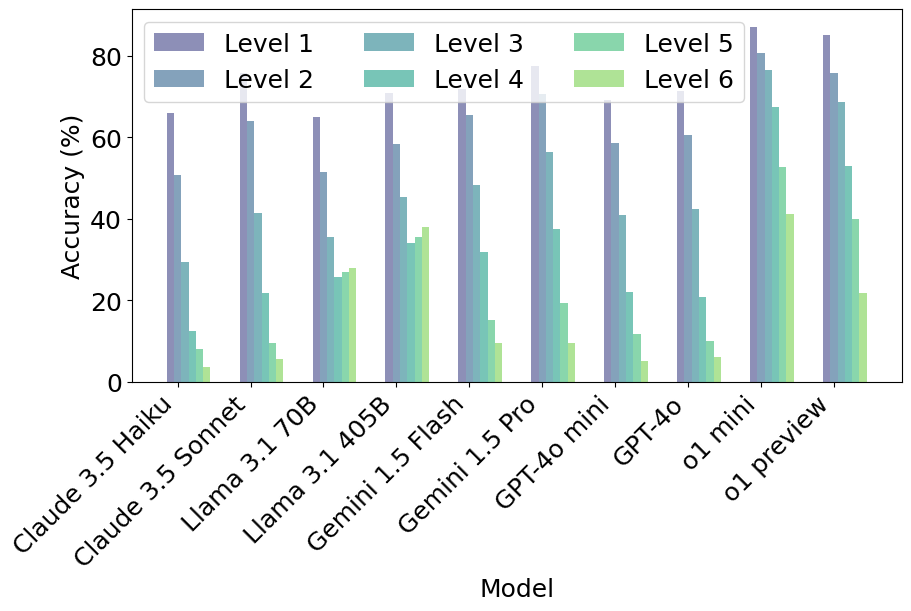

In [21]:
x = np.arange(len(MODELS))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(9,6), layout='constrained')

for lvl in LEVELS:
    accs = [100*bylevel_accs[model][lvl] for model in MODELS]
    offset = width * multiplier
    ax.bar(x + offset, accs, width, label=f"Level {lvl}", color=DIFFICULTY_COLORS[lvl-1])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, MODEL_DISPLAY_NAMES, rotation=45, ha="right")
ax.legend(loc='upper left', ncols=3)

# plt.title("Per-difficulty Performance on HARD of Various Models")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
# plt.grid(axis='y')
plt.savefig(BASEDIR / "../images/HARP_by_level.pdf")
plt.show()

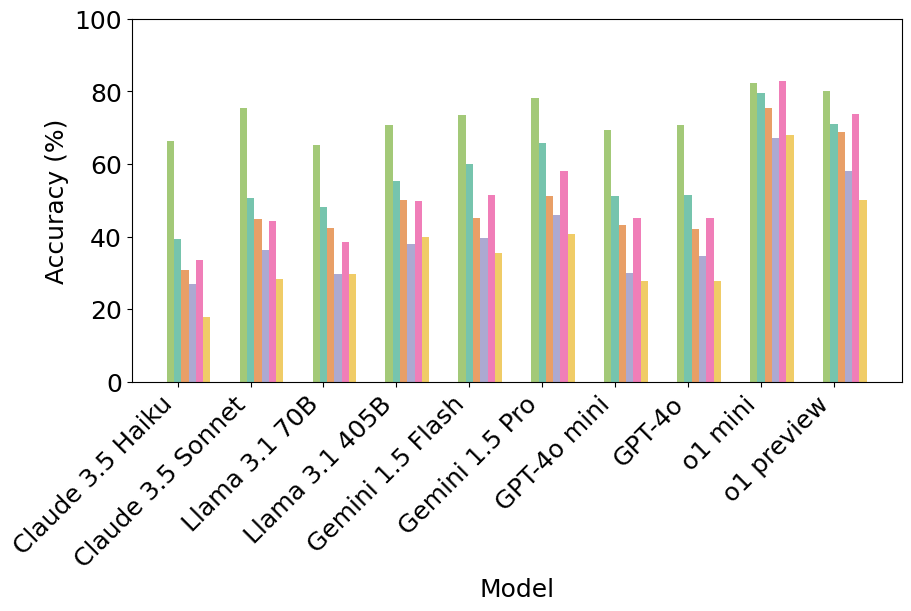

In [22]:
x = np.arange(len(MODELS))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(9,6), layout='constrained')

for subj in SUBJECTS:
    accs = [100*bysubject_accs[model][subj] for model in MODELS]
    offset = width * multiplier
    ax.bar(x + offset, accs, width, label=f"{subj}", color=SUBJECT_COLORS[subj])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, MODEL_DISPLAY_NAMES, rotation=45, ha="right")
# ax.legend(loc='upper right', ncols=3)  # TODO: legend is too big. ignoring since we aren't using this plot
ax.set_ylim(top=100)

# plt.title("Per-subject Performance on HARD of Various Models")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.savefig(BASEDIR / "../images/HARD_by_subject.pdf")
plt.show()

## On just Difficulty 5-6

In [23]:
overall_lvl56_accs = results.query("level >= 5").groupby("model")["is_correct"].mean()
overall_lvl56_accs

model
Meta-Llama-3.1-405B-Instruct-Turbo    0.368020
Meta-Llama-3.1-70B-Instruct-Turbo     0.274112
claude-3-5-haiku-20241022             0.058376
claude-3-5-sonnet-20241022            0.076142
gemini-1.5-flash-002                  0.124365
gemini-1.5-pro-002                    0.144670
gpt-4o-2024-08-06                     0.081218
gpt-4o-mini-2024-07-18                0.083756
o1-mini-2024-09-12                    0.469543
o1-preview-2024-09-12                 0.309645
Name: is_correct, dtype: float64

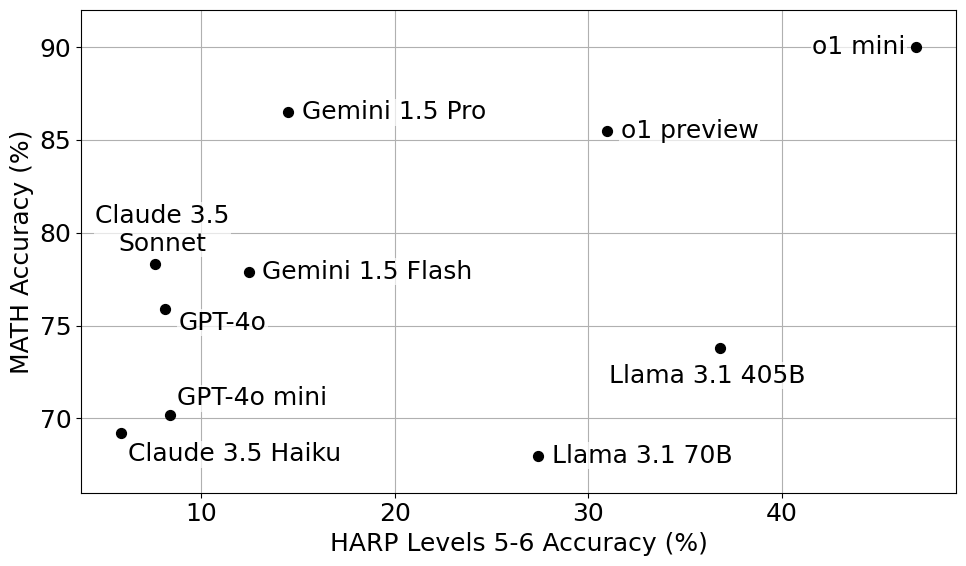

In [24]:
x = [100*overall_lvl56_accs[model] for model in MODELS]
y = [100*hendrycks_math_accuracies[model] for model in MODELS]

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10,6))

label_offsets = {
    "o1 mini": (-75, 0),
#     "o1 preview": (-40, -10),
#     "Gemini 1.5 Pro": (-140, 0),
#     "Gemini 1.5 Flash": (10, -8),
    "Claude 3.5 Sonnet": (5, 25),
    "GPT-4o": (10, -10),
    "Llama 3.1 405B": (-80, -20),
    "GPT-4o mini": (5, 12),
    "Claude 3.5 Haiku": (5, -15),
#     "Llama 3.1 70B": (10, -15)
}

for i, txt in enumerate(MODEL_DISPLAY_NAMES):
    offset = label_offsets.get(txt, (10 ,0))
    ha='left'
    if txt.startswith('Claude 3.5 Sonnet'):
        txt = 'Claude 3.5\n'+txt.split(' ')[-1]
        ha = 'center'
    # bbox makes a white background to avoid weirdness with grid lines
    ax.annotate(txt, (x[i], y[i]), xytext=offset, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1),
                textcoords="offset points", ha=ha, va='center')

# zorder to make sure it's on top
ax.scatter(x, y, color="black", s=50, zorder=10) 
    
# plt.xlim(35, 79)
plt.ylim(66, 92)
plt.xlabel("HARP Levels 5-6 Accuracy (%)")
plt.ylabel("MATH Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig(BASEDIR / "../images/HARPvsMATH_lvl56.pdf", bbox_inches='tight')
plt.show()

## Output Lengths

In [25]:
import tiktoken
tokenizer = tiktoken.get_encoding("o200k_base")

shortans_dataset = [p for p in dataset if not p["contest"].endswith("MO") and not p["multiple_choice_only"]]
solution_token_counts = []
for prob in shortans_dataset:
    info = {
        k: prob[k] for k in ["year", "contest", "number", "level", "subject", "multiple_choice_only"]
    }
    counts = []
    for i in range(1, prob["num_solutions"]+1):
        counts.append(
            len(tokenizer.encode(prob[f"solution_{i}"]))
        )
    info["solution_tokens"] = counts
    solution_token_counts.append(info)

token_counts_by_level = {}
for info in solution_token_counts:
    if info["level"] not in token_counts_by_level:
        token_counts_by_level[info["level"]] = []
    token_counts_by_level[info["level"]].extend(info["solution_tokens"])
# avg_soln_length_by_level = {k: sum(v)/len(v) for k, v in token_counts_by_level.items()}

token_counts_by_level = dict(sorted(token_counts_by_level.items()))

token_counts_by_subject = {}
for info in solution_token_counts:
    if info["subject"] not in token_counts_by_subject:
        token_counts_by_subject[info["subject"]] = []
    token_counts_by_subject[info["subject"]].extend(info["solution_tokens"])
# avg_soln_length_by_subject = {k: sum(v)/len(v) for k, v in token_counts_by_subject.items()}

token_counts_by_subject = dict(sorted(token_counts_by_subject.items()))

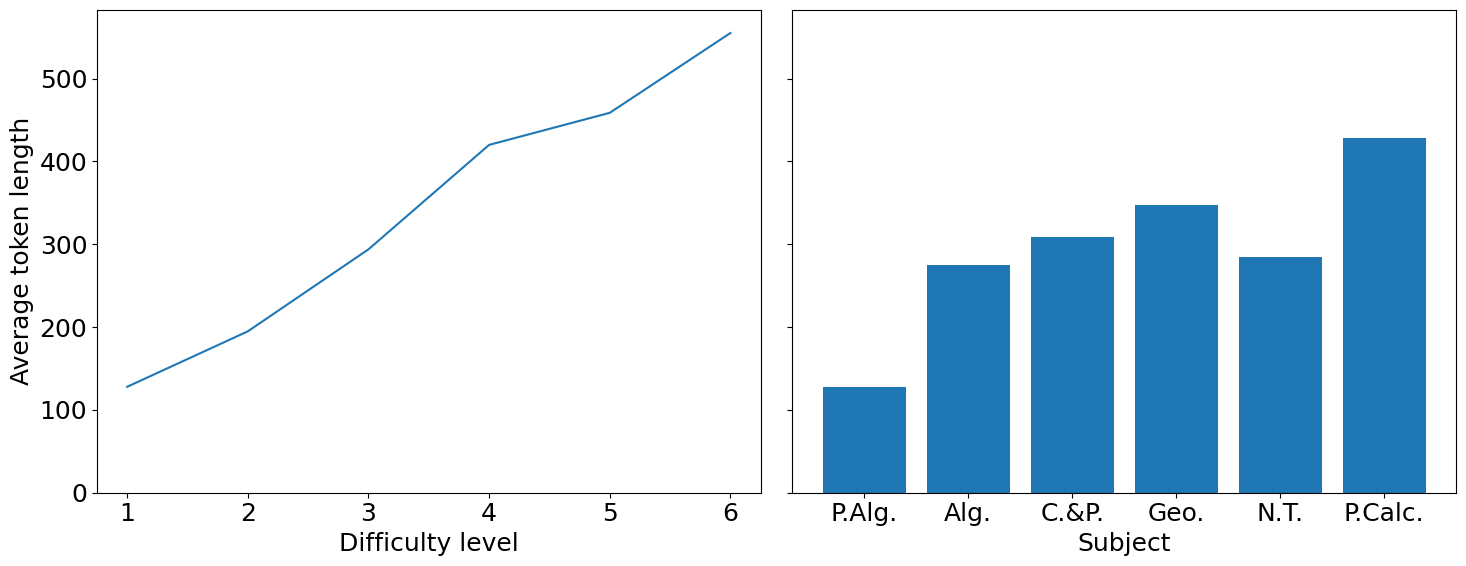

In [26]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].plot(LEVELS, [sum(token_counts_by_level[l]) / len(token_counts_by_level[l]) for l in LEVELS])
axs[0].set_xlabel("Difficulty level")
axs[0].set_ylabel("Average token length")

axs[1].bar(SUBJECTS_DISPLAY_ABBRS, [sum(token_counts_by_subject[s]) / len(token_counts_by_subject[s]) for s in SUBJECTS])
axs[1].set_xlabel("Subject")
# axs[1].set_ylabel("Average token length")
plt.tight_layout()
fig.savefig(BASEDIR / "../images/human_solution_lengths.pdf", bbox_inches="tight")

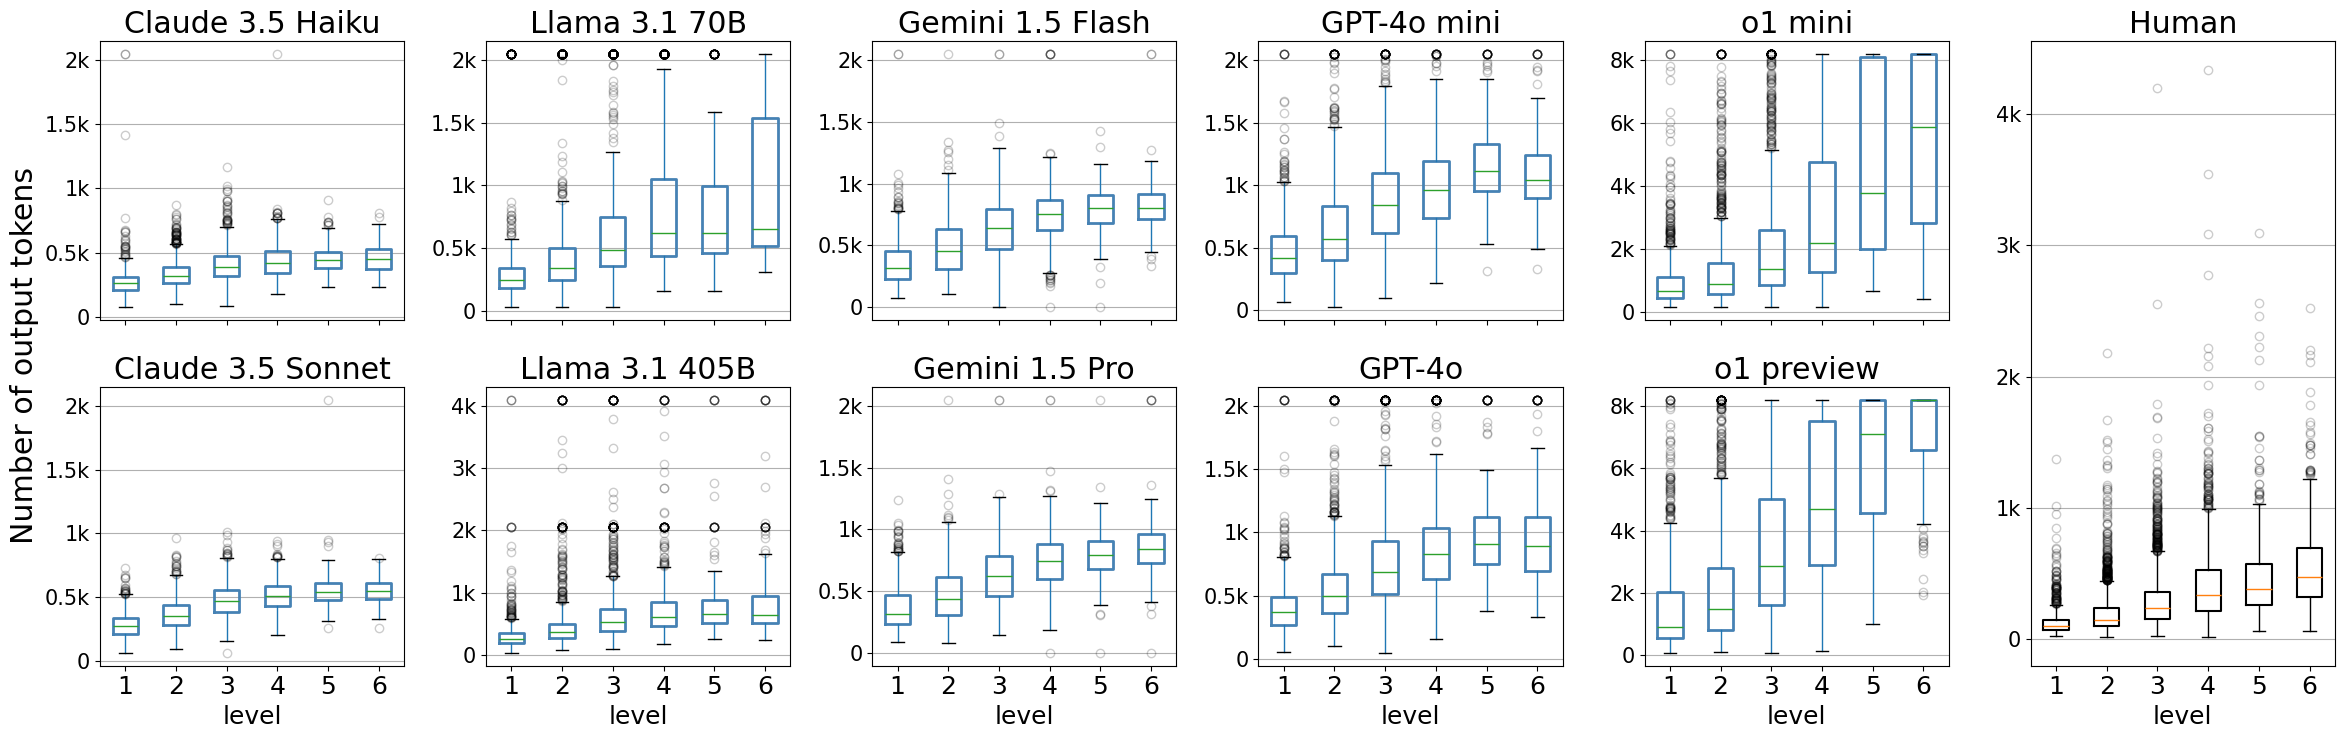

In [27]:
from matplotlib import gridspec

matplotlib.rcParams.update({'font.size': 18})
# fig, axs = plt.subplots(2, 6, figsize=(24, 8), sharex=True)
fig = plt.figure(figsize=(24, 8))
gs = gridspec.GridSpec(2, 6)

for i, (model, display_name) in enumerate(zip(MODELS, MODEL_DISPLAY_NAMES)):
    # ax = axs[i%2, i // 2]
    ax = plt.subplot(gs[i % 2, i // 2])
    results.query("model == @model").boxplot("output_tokens", "level", ax=ax, boxprops={"linewidth": 2, "color": "steelblue"}, flierprops={"marker": "o", "markeredgecolor": "black", "alpha": 0.2})
    max_val = max(results.query("model == @model")["output_tokens"])
    max_val = (max_val // 1000) * 1000 + 1
    ax.set_title(f"{display_name}")#, fontsize=17)
    ax.yaxis.set_tick_params(labelsize=15)
    if i % 2 == 0:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    label_range = list(range(0,max_val,max_val // 4))
    label_range[1:] = [f"{round(x / 1000, 1)}k" if x % 1000 != 0 else f"{x // 1000}k" for x in label_range[1:]]
    ax.set_yticks(list(range(0,max_val,max_val // 4)))
    ax.set_yticklabels(label_range)
    ax.grid(axis="x")
# fig.suptitle("Output tokens generated by various models")
ax_human = plt.subplot(gs[:, -1])
# for i in [0, 1]:
ax_human.boxplot(token_counts_by_level.values(), boxprops={"linewidth": 1.5}, flierprops={"marker": "o", "markeredgecolor": "black", "alpha": 0.2})
ax_human.grid(axis="y")
ax_human.set_title("Human")#, fontsize=17)
ax_human.set_yticks([0,1000,2000,3000,4000])
ax_human.set_yticklabels(["0", "1k", "2k", "3k", "4k"])
ax_human.yaxis.set_tick_params(labelsize=15)
ax_human.set_xlabel("level")
fig.supylabel("Number of output tokens")

fig.suptitle("")
plt.tight_layout()
plt.savefig(BASEDIR / "../images/output_tokens_by_level.pdf")
plt.show()

## Consistency

In [ ]:
# results = (
#     results
#     .unstack("model")
#     .drop(columns=[("reasoning_tokens", m) for m in MODELS if not m.startswith("o1")])
# )

In [ ]:
# model_1 = "Meta-Llama-3.1-405B-Instruct-Turbo"
# model_2 = "Meta-Llama-3.1-70B-Instruct-Turbo"

# print((results[("is_correct", model_1)] == results[("is_correct", model_2)]).mean())
# # ((results[("is_correct", model_1)] == results[("is_correct", model_2)]).mean() - 0.5) / 0.5
# results["is_correct"].value_counts([model_1, model_2]).sort_index().unstack(model_2)

## Gemini: 0-shot vs Minerva

In [28]:
gemini_shots_results = []
for model in [
    "gemini-1.5-flash-002",
    "gemini-1.5-pro-002",
]:
    for mode in ["", "_minerva"]:
        res = pd.read_csv(RESULTS_DIR / model/ f"results{mode}.csv")
        res["model"] = model
        res["prompting"] = "minerva" if mode == "_minerva" else "zero-shot"
        if "reasoning_tokens" not in res.columns:
            res["reasoning_tokens"] = np.nan
        res = res.set_index(["model", "prompting", "uid", "level", "subject"]).sort_index()
        gemini_shots_results.append(res)
gemini_shots_results = pd.concat(gemini_shots_results).drop(columns=["has_asy_problem", "has_asy_solution"])

In [29]:
gemini_shots_overall_accs = gemini_shots_results.groupby(["model", "prompting"])["is_correct"].mean()

gemini_shots_bylevel_accs = gemini_shots_results.groupby(["model", "prompting", "level"])["is_correct"].mean()
gemini_shots_bysubject_accs = gemini_shots_results.groupby(["model", "prompting", "subject"])["is_correct"].mean()

gemini_shots_overall_accs

model                 prompting
gemini-1.5-flash-002  minerva      0.511925
                      zero-shot    0.522594
gemini-1.5-pro-002    minerva      0.563389
                      zero-shot    0.580962
Name: is_correct, dtype: float64

In [30]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(LEVELS)} {'c'*len(SUBJECTS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in LEVELS])
bysubject_header_str = " & ".join(SUBJECTS_DISPLAY_ABBRS)
print(f"Model & Overall Accuracy & {bylevel_header_str} & {bysubject_header_str} \\\\")
print("\\midrule")
for model in [
    "gemini-1.5-flash-002",
    "gemini-1.5-pro-002",
]:
    for mode in ["zero-shot", "minerva"]:
        display_name = (
            ("Gemini 1.5 Pro v2" if model == "gemini-1.5-pro-002" else "Gemini 1.5 Flash v2")
            + ", "
            + ("0-shot" if mode == "zero-shot" else "4-shot Minerva")
        )
        overall_acc = gemini_shots_overall_accs[model][mode]

        by_level_str = " & ".join([f"{100*gemini_shots_bylevel_accs[model][mode][lvl]:.01f}" for lvl in LEVELS])
        by_subject_str = " & ".join([f"{100*gemini_shots_bysubject_accs[model][mode][subj]:.01f}" for subj in SUBJECTS])

        print(f"{display_name} & {100*overall_acc:.01f} & {by_level_str} & {by_subject_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccccc cccccc } 
\toprule
Model & Overall Accuracy & L1 & L2 & L3 & L4 & L5 & L6 & P.Alg. & Alg. & C.&P. & Geo. & N.T. & P.Calc. \\
\midrule
Gemini 1.5 Flash v2, 0-shot & 52.3 & 72.0 & 65.4 & 48.4 & 31.8 & 15.2 & 9.6 & 73.5 & 60.0 & 45.1 & 39.7 & 51.4 & 35.4 \\
Gemini 1.5 Flash v2, 4-shot Minerva & 51.2 & 72.7 & 64.5 & 46.7 & 30.9 & 13.2 & 6.1 & 73.8 & 60.3 & 42.1 & 38.4 & 49.3 & 33.8 \\
Gemini 1.5 Pro v2, 0-shot & 58.1 & 77.5 & 70.6 & 56.4 & 37.6 & 19.3 & 9.6 & 78.2 & 65.7 & 51.2 & 45.9 & 58.1 & 40.8 \\
Gemini 1.5 Pro v2, 4-shot Minerva & 56.3 & 76.7 & 70.1 & 53.4 & 34.8 & 14.2 & 9.6 & 79.4 & 64.3 & 48.8 & 43.5 & 53.1 & 40.4 \\
\bottomrule
\end{tabular}


# MCQ Accuracies

In [31]:
MCQ_LEVELS = list(range(1, 5))

MCQ_VARIANTS = [
    "mcq_fromtext",
    "mcq_newlinedot",
    "mcq_newlineparen",
    "mcq_newlineparen_shuffle1",
    "mcq_newlineparen_shuffle2",
    "mcq_newlineparen_shuffle3",
    "mcq_newlineparen_shuffle4",
    "mcq_newlineparen_shuffle5",
    "mcq_nochoices",
]
MCQ_VARIANT_DISPLAY_NAMES = [
    "Original text",
    "Dot format",
    "Paren format",
    "Paren + shuffle, run 1",
    "Paren + shuffle, run 2",
    "Paren + shuffle, run 3",
    "Paren + shuffle, run 4",
    "Paren + shuffle, run 5",
    "No choices given",
]

In [32]:
mcq_results = []
for prompting_variant in MCQ_VARIANTS:
    res = pd.read_csv(RESULTS_DIR / "gemini-1.5-pro-002" / f"results_{prompting_variant}.csv")
    res["prompting"] = prompting_variant
    if "reasoning_tokens" not in res.columns:
        res["reasoning_tokens"] = np.nan
    res = res.set_index(["prompting", "uid", "level", "subject"]).sort_index()
    mcq_results.append(res)
mcq_results = pd.concat(mcq_results).drop(columns=["has_asy_problem", "has_asy_solution"])

In [33]:
mcq_results.groupby("prompting")["is_correct"].count()

prompting
mcq_fromtext                 4110
mcq_newlinedot               4110
mcq_newlineparen             4110
mcq_newlineparen_shuffle1    4110
mcq_newlineparen_shuffle2    4110
mcq_newlineparen_shuffle3    4110
mcq_newlineparen_shuffle4    4110
mcq_newlineparen_shuffle5    4110
mcq_nochoices                4110
Name: is_correct, dtype: int64

In [34]:
mcq_overall_accs = mcq_results.groupby("prompting")["is_correct"].mean()

mcq_bylevel_accs = mcq_results.groupby(["prompting", "level"])["is_correct"].mean()
mcq_bysubject_accs = mcq_results.groupby(["prompting", "subject"])["is_correct"].mean()

mcq_overall_accs

prompting
mcq_fromtext                 0.804136
mcq_newlinedot               0.806326
mcq_newlineparen             0.810949
mcq_newlineparen_shuffle1    0.806813
mcq_newlineparen_shuffle2    0.809732
mcq_newlineparen_shuffle3    0.804623
mcq_newlineparen_shuffle4    0.798540
mcq_newlineparen_shuffle5    0.803406
mcq_nochoices                0.199757
Name: is_correct, dtype: float64

In [35]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(MCQ_LEVELS)} {'c'*len(SUBJECTS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in MCQ_LEVELS])
bysubject_header_str = " & ".join(SUBJECTS_DISPLAY_ABBRS)
print(f"Prompting Method & Overall & {bylevel_header_str} & {bysubject_header_str} \\\\")
print("\\midrule")
for variant, display_name in zip(MCQ_VARIANTS, MCQ_VARIANT_DISPLAY_NAMES):
    overall_acc = mcq_overall_accs[variant]

    by_level_str = " & ".join([f"{100*mcq_bylevel_accs[variant][lvl]:.01f}" for lvl in MCQ_LEVELS])
    by_subject_str = " & ".join([f"{100*mcq_bysubject_accs[variant][subj]:.01f}" for subj in SUBJECTS])

    print(f"{display_name} & {100*overall_acc:.01f} & {by_level_str} & {by_subject_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccc cccccc } 
\toprule
Prompting Method & Overall & L1 & L2 & L3 & L4 & P.Alg. & Alg. & C.&P. & Geo. & N.T. & P.Calc. \\
\midrule
Original text & 80.4 & 85.8 & 84.2 & 77.7 & 65.1 & 90.4 & 87.0 & 70.8 & 73.8 & 77.2 & 73.7 \\
Dot format & 80.6 & 85.9 & 86.5 & 76.6 & 62.1 & 91.1 & 86.2 & 72.2 & 73.0 & 79.3 & 73.0 \\
Paren format & 81.1 & 87.6 & 86.2 & 76.2 & 64.5 & 92.2 & 87.2 & 71.0 & 73.7 & 79.9 & 71.5 \\
Paren + shuffle, run 1 & 80.7 & 87.4 & 85.4 & 76.1 & 64.7 & 92.7 & 86.4 & 71.3 & 72.4 & 78.9 & 73.0 \\
Paren + shuffle, run 2 & 81.0 & 86.7 & 85.7 & 77.8 & 63.1 & 91.2 & 87.0 & 72.5 & 73.5 & 80.1 & 69.3 \\
Paren + shuffle, run 3 & 80.5 & 87.2 & 85.4 & 76.2 & 62.9 & 91.4 & 85.2 & 72.2 & 73.3 & 78.9 & 71.5 \\
Paren + shuffle, run 4 & 79.9 & 86.1 & 84.7 & 77.2 & 59.5 & 89.8 & 86.7 & 70.0 & 72.2 & 79.5 & 71.5 \\
Paren + shuffle, run 5 & 80.3 & 87.1 & 84.6 & 76.6 & 63.7 & 91.6 & 86.9 & 70.0 & 72.4 & 78.2 & 74.5 \\
No choices given & 20.0 & 19.9 & 19.0 & 20.2 & 22.6 & 2

## Vs Short Answer

In [36]:
mcq_vs_shortans_results = pd.concat([
    (
        results
        .query("model == 'gemini-1.5-pro-002'")
        .reset_index()
        .drop(columns=["model"])
        .assign(prompting="short_ans")
        .query("not uid.str.contains('AIME')", engine="python")
        .set_index(["prompting", "uid", "level", "subject"])
    ),
    mcq_results.query("~mcq_only"),
])
mcq_vs_shortans_results.head()

mcq_only reason  is_correct  \
prompting uid           level subject                                   
short_ans 1950/AHSME/1  2     prealgebra     False   stop        True   
          1950/AHSME/10 2     prealgebra     False   stop        True   
          1950/AHSME/13 2     algebra        False   stop       False   
          1950/AHSME/16 2     algebra        False   stop       False   
          1950/AHSME/17 2     algebra        False   stop        True   

                                                        answer  \
prompting uid           level subject                            
short_ans 1950/AHSME/1  2     prealgebra       $10\frac{2}{3}$   
          1950/AHSME/10 2     prealgebra            $3+\sqrt6$   
          1950/AHSME/13 2     algebra     $0,1,2\text{ and }4$   
          1950/AHSME/16 2     algebra                      $5$   
          1950/AHSME/17 2     algebra        $y=100-5x-5x^{2}$   

                                                       predict  input_tokens  \
prompting uid           level subject                                          
short_ans 1950/AHSME/1  2     prealgebra          \frac{32}{3}            85   
          1950/AHSME/10 2     prealgebra            3+\sqrt{6}            86   
          1950/AHSME/13 2     algebra       \boxed{0, 1, 2, 4}            81   
          1950/AHSME/16 2     algebra                \boxed{3}            89   
          1950/AHSME/17 2     algebra     y = -5x^2 - 5x + 100           138   

                                          output_tokens  reasoning_tokens  
prompting uid           level subject                                      
short_ans 1950/AHSME/1  2     prealgebra            139                 0  
          1950/AHSME/10 2     prealgebra            312                 0  
          1950/AHSME/13 2     algebra               238                 0  
          1950/AHSME/16 2     algebra               247                 0  
          1950/AHSME/17 2     algebra               637                 0

In [37]:
len(
        results
        .query("model == 'gemini-1.5-pro-002'")
        .reset_index()
        .drop(columns=["model"])
        .assign(prompting="short_ans")
        .query("not uid.str.contains('AIME')", engine="python")
        .set_index(["prompting", "uid", "level", "subject"])
)

3797

In [38]:
mcq_vs_shortans_overall_accs = mcq_vs_shortans_results.groupby("prompting")["is_correct"].mean()

mcq_vs_shortans_bylevel_accs = mcq_vs_shortans_results.groupby(["prompting", "level"])["is_correct"].mean()
mcq_vs_shortans_bysubject_accs = mcq_vs_shortans_results.groupby(["prompting", "subject"])["is_correct"].mean()

mcq_vs_shortans_overall_accs

prompting
mcq_fromtext                 0.799579
mcq_newlinedot               0.802212
mcq_newlineparen             0.807216
mcq_newlineparen_shuffle1    0.802739
mcq_newlineparen_shuffle2    0.805373
mcq_newlineparen_shuffle3    0.800895
mcq_newlineparen_shuffle4    0.792468
mcq_newlineparen_shuffle5    0.799579
mcq_nochoices                0.195417
short_ans                    0.642349
Name: is_correct, dtype: float64

In [39]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(MCQ_LEVELS)} {'c'*len(SUBJECTS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in MCQ_LEVELS])
bysubject_header_str = " & ".join([s.replace("&", "\\&") for s in SUBJECTS_DISPLAY_ABBRS])
print(f"Prompting Method & Overall & {bylevel_header_str} & {bysubject_header_str} \\\\")
print("\\midrule")
for variant, display_name in zip(["short_ans", *MCQ_VARIANTS], ["Short answer", *MCQ_VARIANT_DISPLAY_NAMES]):
    overall_acc = mcq_vs_shortans_overall_accs[variant]

    by_level_str = " & ".join([f"{100*mcq_vs_shortans_bylevel_accs[variant][lvl]:.01f}" for lvl in MCQ_LEVELS])
    by_subject_str = " & ".join([f"{100*mcq_vs_shortans_bysubject_accs[variant][subj]:.01f}" for subj in SUBJECTS])

    print(f"{display_name} & {100*overall_acc:.01f} & {by_level_str} & {by_subject_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccc cccccc } 
\toprule
Prompting Method & Overall & L1 & L2 & L3 & L4 & P.Alg. & Alg. & C.\&P. & Geo. & N.T. & P.Calc. \\
\midrule
Short answer & 64.2 & 77.5 & 70.6 & 56.3 & 38.3 & 78.1 & 70.1 & 57.7 & 52.4 & 67.3 & 48.5 \\
Original text & 80.0 & 85.6 & 83.8 & 77.1 & 63.9 & 90.6 & 86.5 & 70.6 & 73.5 & 76.7 & 73.5 \\
Dot format & 80.2 & 85.5 & 85.9 & 76.4 & 60.8 & 90.8 & 86.5 & 71.9 & 73.0 & 78.3 & 72.7 \\
Paren format & 80.7 & 87.1 & 85.9 & 76.0 & 63.2 & 92.1 & 86.8 & 71.1 & 73.6 & 79.5 & 72.0 \\
Paren + shuffle, run 1 & 80.3 & 87.0 & 85.0 & 75.5 & 63.9 & 92.7 & 86.3 & 71.4 & 72.2 & 78.1 & 72.0 \\
Paren + shuffle, run 2 & 80.5 & 86.2 & 85.2 & 77.5 & 61.9 & 91.1 & 86.5 & 72.4 & 73.5 & 80.0 & 68.2 \\
Paren + shuffle, run 3 & 80.1 & 86.6 & 85.0 & 75.7 & 62.6 & 91.4 & 85.2 & 71.9 & 73.3 & 78.1 & 70.5 \\
Paren + shuffle, run 4 & 79.2 & 85.6 & 84.1 & 76.6 & 58.0 & 89.5 & 86.0 & 69.7 & 72.2 & 78.8 & 70.5 \\
Paren + shuffle, run 5 & 80.0 & 86.6 & 84.3 & 76.2 & 62.8 & 91.4

## Llama Short Answer vs MCQ

In [40]:
llama_mcq_vs_shortans_results = pd.concat([
    (
        results
        .query("model == 'Meta-Llama-3.1-70B-Instruct-Turbo'")
        .reset_index()
        .drop(columns=["model"])
        .assign(prompting="short_ans")
        .query("not uid.str.contains('AIME')", engine="python")
        .set_index(["prompting", "uid", "level", "subject"])
    ),
    (
        pd.read_csv(RESULTS_DIR / f"Meta-Llama-3.1-70B-Instruct-Turbo/results_mcq_nochoices.csv")
        .assign(prompting="mcq_nochoices", reasoning_tokens=np.nan)
        .set_index(["prompting", "uid", "level", "subject"])
        .sort_index()
        .drop(columns=["has_asy_problem", "has_asy_solution"])
        .query("~mcq_only")
    ),
])
llama_mcq_vs_shortans_results.head()

mcq_only  reason  is_correct  \
prompting uid           level subject                                    
short_ans 1950/AHSME/1  2     prealgebra     False    stop       False   
          1950/AHSME/10 2     prealgebra     False    stop       False   
          1950/AHSME/13 2     algebra        False    stop       False   
          1950/AHSME/16 2     algebra        False    stop        True   
          1950/AHSME/17 2     algebra        False  length       False   

                                                        answer  \
prompting uid           level subject                            
short_ans 1950/AHSME/1  2     prealgebra       $10\frac{2}{3}$   
          1950/AHSME/10 2     prealgebra            $3+\sqrt6$   
          1950/AHSME/13 2     algebra     $0,1,2\text{ and }4$   
          1950/AHSME/16 2     algebra                      $5$   
          1950/AHSME/17 2     algebra        $y=100-5x-5x^{2}$   

                                                                    predict  \
prompting uid           level subject                                         
short_ans 1950/AHSME/1  2     prealgebra  \boxed{16/3 * 2/2 = 32/3 = 10.67}   
          1950/AHSME/10 2     prealgebra                   \boxed{\sqrt{3}}   
          1950/AHSME/13 2     algebra                    \boxed{0, 1, 2, 4}   
          1950/AHSME/16 2     algebra                                     5   
          1950/AHSME/17 2     algebra                                   NaN   

                                          input_tokens  output_tokens  \
prompting uid           level subject                                   
short_ans 1950/AHSME/1  2     prealgebra           188            155   
          1950/AHSME/10 2     prealgebra           193            522   
          1950/AHSME/13 2     algebra              185            182   
          1950/AHSME/16 2     algebra              195            333   
          1950/AHSME/17 2     algebra              244           2048   

                                          reasoning_tokens  
prompting uid           level subject                       
short_ans 1950/AHSME/1  2     prealgebra               0.0  
          1950/AHSME/10 2     prealgebra               0.0  
          1950/AHSME/13 2     algebra                  0.0  
          1950/AHSME/16 2     algebra                  0.0  
          1950/AHSME/17 2     algebra                  0.0

In [41]:
len(llama_mcq_vs_shortans_results) / 2

3797.0

In [42]:
llama_mcq_vs_shortans_overall_accs = llama_mcq_vs_shortans_results.groupby("prompting")["is_correct"].mean()

llama_mcq_vs_shortans_bylevel_accs = llama_mcq_vs_shortans_results.groupby(["prompting", "level"])["is_correct"].mean()
llama_mcq_vs_shortans_bysubject_accs = llama_mcq_vs_shortans_results.groupby(["prompting", "subject"])["is_correct"].mean()

llama_mcq_vs_shortans_overall_accs

prompting
mcq_nochoices    0.195154
short_ans        0.460890
Name: is_correct, dtype: float64

In [43]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(MCQ_LEVELS)} {'c'*len(SUBJECTS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in MCQ_LEVELS])
bysubject_header_str = " & ".join([s.replace("&", "\\&") for s in SUBJECTS_DISPLAY_ABBRS])
print(f"Prompting Method & Overall & {bylevel_header_str} & {bysubject_header_str} \\\\")
print("\\midrule")
for variant, display_name in zip(["short_ans", "mcq_nochoices"], ["Short answer", "No choices given"]):
    overall_acc = llama_mcq_vs_shortans_overall_accs[variant]

    by_level_str = " & ".join([f"{100*llama_mcq_vs_shortans_bylevel_accs[variant][lvl]:.01f}" for lvl in MCQ_LEVELS])
    by_subject_str = " & ".join([f"{100*llama_mcq_vs_shortans_bysubject_accs[variant][subj]:.01f}" for subj in SUBJECTS])

    print(f"{display_name} & {100*overall_acc:.01f} & {by_level_str} & {by_subject_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccc cccccc } 
\toprule
Prompting Method & Overall & L1 & L2 & L3 & L4 & P.Alg. & Alg. & C.\&P. & Geo. & N.T. & P.Calc. \\
\midrule
Short answer & 46.1 & 65.0 & 51.4 & 33.9 & 23.2 & 65.8 & 52.2 & 43.1 & 31.0 & 39.2 & 31.1 \\
No choices given & 19.5 & 19.5 & 22.7 & 15.8 & 17.5 & 23.3 & 19.7 & 19.8 & 17.6 & 16.1 & 18.2 \\
\bottomrule
\end{tabular}


# Pass@k and Maj@k

The figure-generating code is a copy from `notebooks/analysis/gemini-1-5-pro_passk.ipynb`, put here to make it easier to regenerate all paper figures and tables at once if desired.

In [102]:
def get_problem_uid(resp_uid):
    p_uid = resp_uid.split("/")
    return "/".join([*p_uid[:-1], p_uid[-1].split("_")[0]])

def get_gen_num(resp_uid):
    p_uid = resp_uid.split("/")
    if "_" not in p_uid[-1]:
        return 0
    else:
        return int(p_uid[-1].split("_")[1])

passk_results = (
    pd.read_csv(RESULTS_DIR / "gemini-1.5-pro-002_passk/results.csv").set_index("uid")
    .query("subject != 'calculus'")
)
passk_results["p_uid"] = [get_problem_uid(uid) for uid in passk_results.index]
passk_results["gen_num"] = [get_gen_num(uid) for uid in passk_results.index]
passk_results = passk_results.set_index(["p_uid", "gen_num"])

maj_at_df = pd.read_csv(RESULTS_DIR / 'gemini-1.5-pro-002_passk/majk.csv').set_index('p_uid')
maj_at_df = maj_at_df[maj_at_df.index.isin(sa_dataset_map.keys())]

In [86]:
def compute_pass_at_k(df, k):
    if k > 64:
        raise ValueError("We only have 64 samples")
    return (
        df
        .groupby("p_uid")
        ["is_correct"].apply(lambda x: 1 - math.comb(64-x.sum(), k)/math.comb(64, k))
    )

In [121]:
overall_pass_at_accuracies = []
for e in range(0, 7):
    k = 2 ** e
    pass_acc = compute_pass_at_k(passk_results, k=k).mean()
    print(f"pass@{k} accuracy: {100 * pass_acc:.02f}")
    overall_pass_at_accuracies.append(pass_acc)

pass@1 accuracy: 57.26
pass@2 accuracy: 64.88
pass@4 accuracy: 71.02
pass@8 accuracy: 76.02
pass@16 accuracy: 80.03
pass@32 accuracy: 83.23
pass@64 accuracy: 85.73


In [105]:
NUM_MAJK_SAMPLES = int(len(maj_at_df) / len(maj_at_df.index.unique()))

In [145]:
maj_at_df_by_ordering = [maj_at_df.iloc[i::NUM_MAJK_SAMPLES] for i in range(NUM_MAJK_SAMPLES)]
maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i].mean()) for i in range(NUM_MAJK_SAMPLES)])
overall_maj_at_mean = np.mean(maj_at_per_ordering, axis=0)
overall_maj_at_std = np.std(maj_at_per_ordering, axis=0, ddof=1)
overall_maj_at_accuracies = [{"mean": overall_maj_at_mean[i], "std": overall_maj_at_std[i]} for i in range(len(overall_maj_at_mean))]
print(mean, "\n", std)

[0.1106599  0.11269036 0.12944162 0.16353638 0.18117597 0.19478638
 0.1928934 ] 
 [0.01362072 0.01055667 0.01354959 0.01735792 0.01553928 0.0087788
 0.        ]


In [119]:
maj_levels = np.array([passk_results.loc[(p, 0)]['level'] for p in maj_at_df_by_ordering[0].index])
t_value = stats.t.ppf((1 + 0.95) / 2, NUM_MAJK_SAMPLES-1)

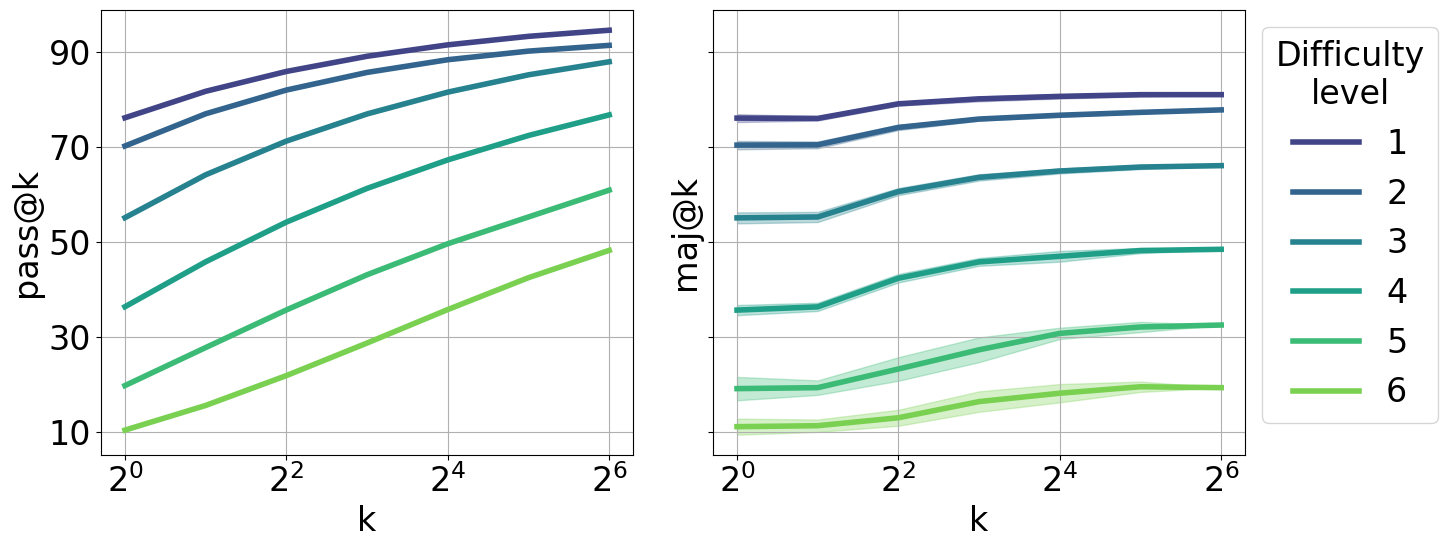

In [164]:
matplotlib.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(15,6)

pass_at_accuracies_by_level = {}
maj_at_accuracies_by_level = {}
for i, difficulty in enumerate(range(1, 7)):
    ## pass@
    pass_at_accuracies = []
    for e in range(0, 7):
        k = 2 ** e
        pass_acc = compute_pass_at_k(passk_results[passk_results['level'] == difficulty], k=k).mean()
        pass_at_accuracies.append(pass_acc)

    pass_at_accuracies_by_level[difficulty] = pass_at_accuracies
    
    axs[0].plot([2**e for e in range(0,7)], [acc*100 for acc in pass_at_accuracies],
                label=str(difficulty), lw=4, c=DIFFICULTY_PLOT_COLORS[i])

    ## maj@
    maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i][maj_levels == difficulty].mean()) for i in range(NUM_MAJK_SAMPLES)])
    mean = np.mean(maj_at_per_ordering, axis=0)
    std = np.std(maj_at_per_ordering, axis=0, ddof=1)

    axs[1].fill_between([2**e for e in range(0,7)], 100*(mean-t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), 
                     100*(mean+t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), alpha=0.3, color=DIFFICULTY_PLOT_COLORS[i])
    axs[1].plot([2**e for e in range(0,7)], 100*mean, label=str(difficulty), lw=4, c=DIFFICULTY_PLOT_COLORS[i])

    maj_at_accuracies_by_level[difficulty] = {"mean": mean, "std": std}
    
for i in range(2):
    axs[i].set_xscale("log", base=2)
    axs[i].set_xlabel("k")
    axs[i].grid(True)

axs[0].set_ylabel("pass@k")
axs[0].set_yticks([10, 30, 50, 70, 90])
axs[0].set_xticks([1, 4, 16, 64])
axs[1].set_ylabel("maj@k")
axs[1].legend(title='Difficulty\nlevel', bbox_to_anchor=(1,1), loc='upper left').get_title().set_multialignment('center')
# plt.show()
plt.tight_layout()
fig.savefig(BASEDIR / '../images/gemini_passk_majk_comp_v2.pdf', bbox_inches='tight')

In [137]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(LEVELS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in LEVELS])
print(f"$\\text{{Pass}}@k$ & Overall & {bylevel_header_str} \\\\")
print("\\midrule")
for e in range(0, 7):
    k = 2**e

    overall_acc = overall_pass_at_accuracies[e]
    passat_acc_by_diff = [pass_at_accuracies_by_level[d][e] for d in LEVELS]

    bydiff_str = " & ".join([f"{100*acc:.1f}" for acc in passat_acc_by_diff])
    
    print(f"$\\text{{Pass}}@{k}$ & {overall_acc*100:.1f} & {bydiff_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccccc } 
\toprule
$\text{Pass}@k$ & Overall & L1 & L2 & L3 & L4 & L5 & L6 \\
\midrule
$\text{Pass}@1$ & 57.3 & 76.2 & 70.2 & 55.1 & 36.3 & 19.7 & 10.3 \\
$\text{Pass}@2$ & 64.9 & 81.7 & 77.0 & 64.2 & 45.8 & 27.7 & 15.5 \\
$\text{Pass}@4$ & 71.0 & 85.9 & 82.0 & 71.3 & 54.2 & 35.7 & 21.8 \\
$\text{Pass}@8$ & 76.0 & 89.1 & 85.7 & 77.0 & 61.3 & 43.1 & 28.7 \\
$\text{Pass}@16$ & 80.0 & 91.5 & 88.4 & 81.6 & 67.3 & 49.6 & 35.8 \\
$\text{Pass}@32$ & 83.2 & 93.3 & 90.2 & 85.2 & 72.4 & 55.3 & 42.5 \\
$\text{Pass}@64$ & 85.7 & 94.6 & 91.4 & 88.0 & 76.8 & 60.9 & 48.2 \\
\bottomrule
\end{tabular}


In [147]:
print(f"\\begin{{tabular}}{{ l c {'c'*len(LEVELS)} }} ")
print("\\toprule")
bylevel_header_str = " & ".join([f"L{l}" for l in LEVELS])
print(f"$\\text{{Maj}}@k$ & Overall & {bylevel_header_str} \\\\")
print("\\midrule")
for e in range(0, 7):
    k = 2**e

    if e < 6:
        overall_acc = f'{100*overall_maj_at_accuracies[e]["mean"]:.1f} $\\pm$ {100*overall_maj_at_accuracies[e]["std"]*t_value/np.sqrt(NUM_MAJK_SAMPLES):.1f}'
        majat_acc_by_diff = [{"mean": maj_at_accuracies_by_level[d]["mean"][e], "std": maj_at_accuracies_by_level[d]["std"][e]} for d in LEVELS]
    
        bydiff_str = " & ".join([f'{100*acc["mean"]:.1f} $\\pm$ {100*acc["std"]*t_value/np.sqrt(NUM_MAJK_SAMPLES):.1f}' for acc in majat_acc_by_diff])
    else:
        overall_acc = f'{100*overall_maj_at_accuracies[e]["mean"]:.1f}'
        majat_acc_by_diff = [{"mean": maj_at_accuracies_by_level[d]["mean"][e], "std": maj_at_accuracies_by_level[d]["std"][e]} for d in LEVELS]
    
        bydiff_str = " & ".join([f'{100*acc["mean"]:.1f}' for acc in majat_acc_by_diff])
    
    print(f"$\\text{{Maj}}@{k}$ & {overall_acc} & {bydiff_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{ l c cccccc } 
\toprule
$\text{Maj}@k$ & Overall & L1 & L2 & L3 & L4 & L5 & L6 \\
\midrule
$\text{Maj}@1$ & 57.2 $\pm$ 0.3 & 76.1 $\pm$ 0.8 & 70.4 $\pm$ 0.9 & 55.1 $\pm$ 1.2 & 35.6 $\pm$ 1.1 & 19.1 $\pm$ 2.5 & 11.1 $\pm$ 1.7 \\
$\text{Maj}@2$ & 57.4 $\pm$ 0.4 & 76.0 $\pm$ 0.5 & 70.5 $\pm$ 0.7 & 55.3 $\pm$ 1.1 & 36.3 $\pm$ 0.9 & 19.3 $\pm$ 1.5 & 11.3 $\pm$ 1.3 \\
$\text{Maj}@4$ & 61.7 $\pm$ 0.4 & 79.1 $\pm$ 0.4 & 74.1 $\pm$ 0.6 & 60.6 $\pm$ 0.7 & 42.4 $\pm$ 0.9 & 23.2 $\pm$ 2.5 & 12.9 $\pm$ 1.7 \\
$\text{Maj}@8$ & 64.1 $\pm$ 0.2 & 80.2 $\pm$ 0.5 & 75.9 $\pm$ 0.3 & 63.6 $\pm$ 0.7 & 45.8 $\pm$ 0.8 & 27.3 $\pm$ 2.6 & 16.4 $\pm$ 2.2 \\
$\text{Maj}@16$ & 65.2 $\pm$ 0.2 & 80.7 $\pm$ 0.4 & 76.7 $\pm$ 0.3 & 65.0 $\pm$ 0.5 & 47.0 $\pm$ 1.1 & 30.7 $\pm$ 1.2 & 18.1 $\pm$ 1.9 \\
$\text{Maj}@32$ & 66.0 $\pm$ 0.1 & 81.0 $\pm$ 0.4 & 77.3 $\pm$ 0.2 & 65.8 $\pm$ 0.4 & 48.2 $\pm$ 0.5 & 32.1 $\pm$ 1.1 & 19.5 $\pm$ 1.1 \\
$\text{Maj}@64$ & 66.3 & 81.0 & 77.8 & 66.1 & 48.4 & 32.5 & 19.3 \\
\

# In-context Learning Experiments

See how different few-shots might affect the performance of Gemini 1.5 Pro v2. Vary the level or subject of the demonstrations and the problem.

## Difficulty

In [149]:
with open(BASEDIR / "outputs/short_answer/icl_bylevel_problems.pkl", "rb") as f:
    picked_bylevel_problems = pickle.load(f)

In [151]:
lvl_results = []
for i in range(6):
    lvl_results.append(
        pd.read_csv(RESULTS_DIR / f"gemini-1.5-pro-002/results_sa_icl-lvl_{i+1}.csv")
    )

In [152]:
for i in range(6):
    print(f'Demonstrations of level {i+1} has accuracy {100*lvl_results[i]["is_correct"].mean():.02f}')

Demonstrations of level 1 has accuracy 45.17
Demonstrations of level 2 has accuracy 44.00
Demonstrations of level 3 has accuracy 45.00
Demonstrations of level 4 has accuracy 46.17
Demonstrations of level 5 has accuracy 47.83
Demonstrations of level 6 has accuracy 46.33


In [153]:
bylevel_matrix = []
for i in range(6):
    bylevel_matrix.append(
        lvl_results[i].groupby("level")["is_correct"].mean().to_frame().rename(columns={"is_correct": i+1})
    )
bylevel_matrix = pd.concat(bylevel_matrix, axis=1)
bylevel_matrix * 100

,1,2,3,4,5,6
level,,,,,,
1,73.0,72.0,77.0,74.0,78.0,77.0
2,77.0,72.0,71.0,72.0,75.0,75.0
3,58.0,57.0,56.0,53.0,59.0,52.0
4,42.0,40.0,44.0,45.0,44.0,44.0
5,16.0,16.0,14.0,21.0,21.0,21.0
6,5.0,7.0,8.0,12.0,10.0,9.0


## Subject

In [154]:
subj_results = []
for i, subj in enumerate(SUBJECTS):
    subj_results.append(
        pd.read_csv(RESULTS_DIR / f"gemini-1.5-pro-002/results_sa_icl-subject_{subj}.csv")
    )

In [155]:
for i, subj in enumerate(SUBJECTS):
    print(f'Demonstrations of subject {subj} has accuracy {100*subj_results[i]["is_correct"].mean():.02f}')

Demonstrations of subject prealgebra has accuracy 56.50
Demonstrations of subject algebra has accuracy 61.17
Demonstrations of subject counting_and_probability has accuracy 59.00
Demonstrations of subject geometry has accuracy 60.50
Demonstrations of subject number_theory has accuracy 57.67
Demonstrations of subject precalculus has accuracy 58.17


In [156]:
bysubject_matrix = []
for i, subj in enumerate(SUBJECTS):
    bysubject_matrix.append(
        subj_results[i].groupby("subject")["is_correct"].mean().to_frame().rename(columns={"is_correct": subj})
    )
bysubject_matrix = pd.concat(bysubject_matrix, axis=1)
bysubject_matrix.loc[SUBJECTS] * 100

,prealgebra,algebra,counting_and_probability,geometry,number_theory,precalculus
subject,,,,,,
prealgebra,78.0,85.0,83.0,85.0,79.0,83.0
algebra,65.0,72.0,68.0,63.0,68.0,74.0
counting_and_probability,46.0,53.0,51.0,53.0,50.0,49.0
geometry,52.0,56.0,53.0,58.0,52.0,45.0
number_theory,55.0,56.0,52.0,57.0,51.0,57.0
precalculus,43.0,45.0,47.0,47.0,46.0,41.0


## Merged plot

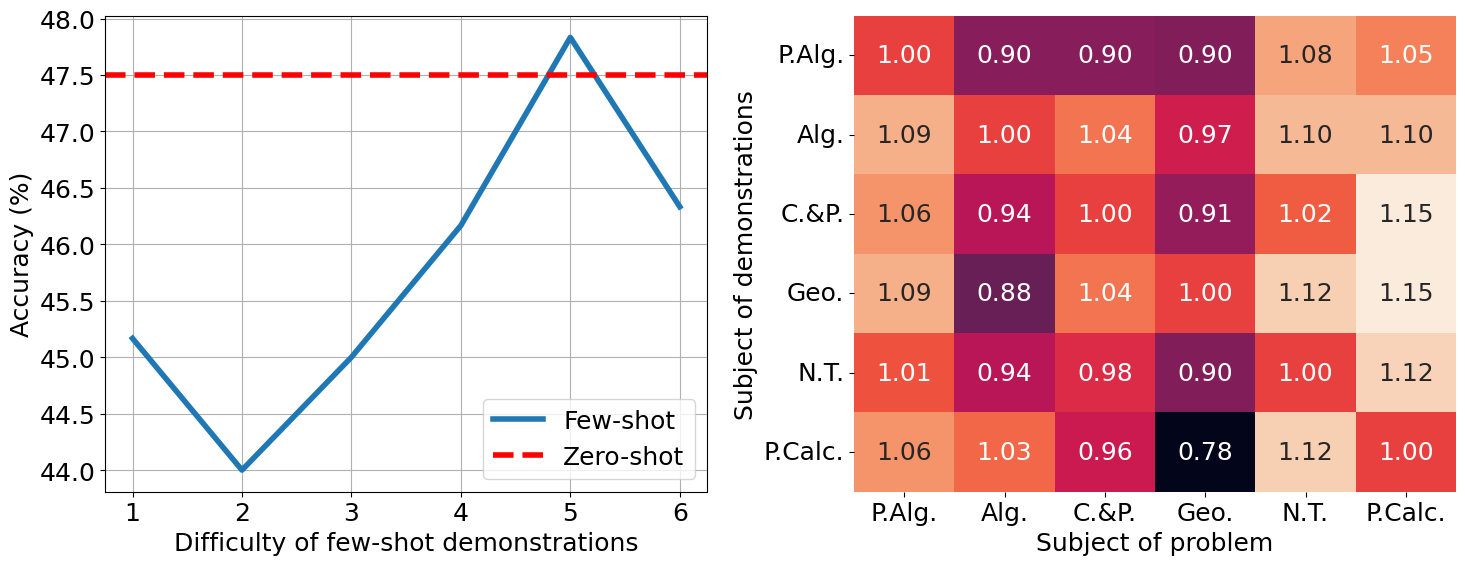

In [158]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,6)

axs[0].plot(LEVELS, [100 * lvl_df["is_correct"].mean() for lvl_df in lvl_results], lw=4, label="Few-shot")
axs[0].axhline(
    100 * results.query("model == 'gemini-1.5-pro-002'")[[
        u in itertools.chain(*picked_bylevel_problems.values()) for u in results.query("model == 'gemini-1.5-pro-002'").reset_index()["uid"]
    ]]["is_correct"].mean(),
    linestyle="--",
    color="red",
    lw=4,
    label="Zero-shot",
)

axs[0].set_xlabel("Difficulty of few-shot demonstrations")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

plot_args = dict() # {'cmap': 'Blues', 'linecolor': '#dddddd', 'linewidths': 2}
subj_corr = np.zeros((6, 6)).astype(float)
for j, subj in enumerate(SUBJECTS):
    for i, demo_subj in enumerate(SUBJECTS):
        subj_corr[i,j] = bysubject_matrix[demo_subj][subj] / bysubject_matrix[subj][subj]

heatmap = sns.heatmap(subj_corr, annot=True, **plot_args,
                      fmt='.02f', ax=axs[1], cbar=False,
                      xticklabels=SUBJECTS_DISPLAY_ABBRS,
                      yticklabels=SUBJECTS_DISPLAY_ABBRS)
plt.yticks(rotation=0)
axs[1].set_xlabel("Subject of problem")
axs[1].set_ylabel("Subject of demonstrations")

plt.tight_layout()
plt.savefig(BASEDIR / "../images/icl.pdf")